In [2]:
# CELL 1: Load CSV and Basic Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from nilearn import plotting, image
import matplotlib.pyplot as plt

# Load subject info from CSV
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Session start mapping (for special cases)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Cope mapping: Key -> (Cope Number, Multiplier)
# Multiplier 1  = Use contrast as is (e.g., Face > Scramble)
# Multiplier -1 = Invert contrast (e.g., Face > Word becomes Word > Face)

COPE_MAP = {
    'face':   (10, 1),   # Face > Scramble
    'word':   (13, -1),  # Face > Word (INVERTED to create Word > Face)
    'object': (3,  1),   # Object > Scramble
    'house':  (11, 1)    # House > Scramble
}

# Parcels are touchy. 
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform', 'inferiortemporal'], # needed to add IT to capture VWFA
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

print("✓ CSV loaded and configuration set")

✓ CSV loaded and configuration set


In [3]:
# CELL 2: Streamlined Subject Loading and Configuration
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Streamlined subject loading with proper configuration"""
    
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        # Get available sessions
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
        
        # Proper hemisphere mapping
        if row['patient'] == 1:  # Patients
            hemisphere_full = row.get('intact_hemi', 'left')
            hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        else:  # Controls 
            hemisphere = 'r'  # Default for controls (we'll add bilateral later)
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None,
            'surgery_side': row.get('SurgerySide', None) if row['patient'] == 1 else None
        }
    
    return subjects

# Load subjects systematically
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)

# Start with original subjects only
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print("STREAMLINED SUBJECT LOADING COMPLETE")
print("="*50)
print(f"Patients loaded: {len(ALL_PATIENTS)}")
print(f"  - OTC: {len(OTC_PATIENTS)}")
print(f"  - nonOTC: {len(NON_OTC_PATIENTS)}")
print(f"Controls loaded: {len(ALL_CONTROLS)}")
print(f"Total analysis subjects: {len(ANALYSIS_SUBJECTS)}")

print(f"\nCORRECT CATEGORY_PARCELS:")
for category, parcels in CATEGORY_PARCELS.items():
    print(f"  {category:6s}: {parcels}")

print(f"\nSample subjects:")
for subj_id, info in list(ANALYSIS_SUBJECTS.items())[:3]:
    print(f"  {info['code']}: {info['group']} {info['patient_status']}, hemi='{info['hemi']}'")

STREAMLINED SUBJECT LOADING COMPLETE
Patients loaded: 16
  - OTC: 7
  - nonOTC: 9
Controls loaded: 9
Total analysis subjects: 25

CORRECT CATEGORY_PARCELS:
  face  : ['fusiform']
  word  : ['fusiform', 'inferiortemporal']
  object: ['lateraloccipital']
  house : ['parahippocampal', 'lingual', 'isthmuscingulate']

Sample subjects:
  OTC004: OTC patient, hemi='l'
  nonOTC007: nonOTC patient, hemi='r'
  OTC008: OTC patient, hemi='l'


In [20]:
# CELL 3: Functional ROI Extraction (FIXED IMPORTS)
from scipy.ndimage import label, center_of_mass # <--- THIS WAS MISSING
import numpy as np
import nibabel as nib

def extract_functional_rois_bilateral(subject_id, threshold_z=2.3, min_cluster_size=30):
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in COPE_MAP.items():
            # Unpack Tuple
            cope_num, multiplier = cope_params if isinstance(cope_params, tuple) else (cope_params, 1)
            
            # Load Search Mask
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): continue
            
            try:
                search_mask = nib.load(mask_file).get_fdata() > 0
                affine = nib.load(mask_file).affine
            except: continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): continue
                
                try:
                    # Load & Invert
                    zstat = nib.load(cope_file).get_fdata() * multiplier
                    
                    # Threshold
                    suprathresh = (zstat > threshold_z) & search_mask
                    
                    # Cluster & Filter
                    labeled, n_clusters = label(suprathresh) # <--- This is where it failed
                    if n_clusters == 0: continue
                    
                    best_idx = -1
                    max_peak = -999
                    
                    for i in range(1, n_clusters + 1):
                        cluster_mask = (labeled == i)
                        if np.sum(cluster_mask) >= min_cluster_size:
                            peak_val = np.max(zstat[cluster_mask])
                            if peak_val > max_peak:
                                max_peak = peak_val
                                best_idx = i
                    
                    if best_idx == -1: continue 
                    
                    # Save Result
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': zstat[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask
                    }
                except Exception as e: print(f"Err {subject_id} {category}: {e}")

    return all_results

# EXECUTE
print("Re-running extraction...")
golarai_functional_final = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_functional_rois_bilateral(sub, min_cluster_size=30)
    if res: golarai_functional_final[sub] = res
print(f"✓ Extraction Complete: {len(golarai_functional_final)} subjects.")

Re-running extraction...
✓ Extraction Complete: 24 subjects.


In [ ]:
# CELL 4: Verify Selectivity (Tuple Corrected)
def verify_roi_selectivity(functional_results, subjects, sample_ids=['OTC004', 'control025']):
    print("\nROI SELECTIVITY CHECK")
    print("="*40)
    
    for pid in sample_ids:
        # Find full ID
        sid = next((k for k,v in subjects.items() if v['code'] == pid), None)
        if not sid or sid not in functional_results: continue
        
        print(f"\n>> {pid}:")
        res = functional_results[sid]
        first_ses = subjects[sid]['sessions'][0]
        
        for roi_name in sorted(res.keys()):
            if first_ses not in res[roi_name]: continue
            roi_mask = res[roi_name][first_ses]['roi_mask']
            target_cat = roi_name.split('_')[1]
            
            scores = {}
            feat_dir = BASE_DIR / sid / f'ses-{first_ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            for cat, (cope, mult) in COPE_MAP.items():
                f = feat_dir / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
                if f.exists():
                    d = nib.load(f).get_fdata() * mult
                    scores[cat] = np.mean(d[roi_mask])
            
            top = max(scores, key=scores.get)
            mark = "✓" if top == target_cat else "✗"
            print(f"  {roi_name:10s}: {mark} Top={top} (Target: {scores.get(target_cat,0):.2f})")
            
verify_roi_selectivity(golarai_functional_final, ANALYSIS_SUBJECTS)


ROI SELECTIVITY CHECK

>> OTC004:
  l_face    : ✓ Top=face (Target: 2.67)
  l_house   : ✓ Top=house (Target: 3.08)
  l_object  : ✓ Top=object (Target: 3.53)
  l_word    : ✓ Top=word (Target: 2.90)

>> control025:
  l_face    : ✓ Top=face (Target: 6.56)
  l_house   : ✓ Top=house (Target: 4.29)
  l_object  : ✓ Top=object (Target: 5.16)
  l_word    : ✓ Top=word (Target: 4.15)
  r_face    : ✓ Top=face (Target: 5.65)
  r_house   : ✓ Top=house (Target: 4.22)
  r_object  : ✓ Top=object (Target: 5.00)
  r_word    : ✓ Top=word (Target: 3.28)


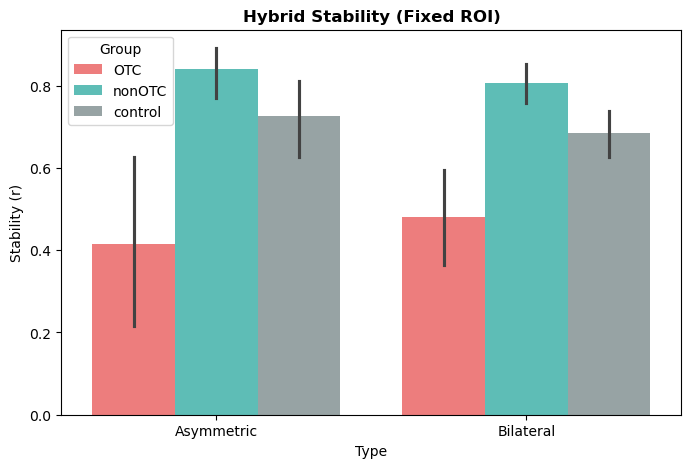

              mean                count          
Type    Asymmetric Bilateral Asymmetric Bilateral
Group                                            
OTC          0.414     0.480          9         9
control      0.726     0.685         34        36
nonOTC       0.841     0.808         18        18


In [ ]:
# CELL 5: Hybrid Stability (Fixed: Adds Subject ID)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from pathlib import Path

def compute_hybrid_stability(functional_results, subjects, min_voxels=50):
    # Define Dictionaries locally
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {
        'face': 'Asymmetric', 'word': 'Asymmetric',
        'house': 'Bilateral', 'object': 'Bilateral'
    }
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        first_ses = sessions[0]
        
        for roi_name, roi_data in res.items():
            cat = roi_name.split('_')[1]
            if first_ses not in roi_data: continue
            
            # 1. Fixed ROI from Session 1
            mask = roi_data[first_ses]['roi_mask']
            if np.sum(mask) < min_voxels: continue
            
            # 2. Extract using Robust Cope
            patterns = {}
            valid_extraction = True
            
            for ses in sessions:
                f = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z = f / f'cope{EXTRACTION_MAP[cat]}.feat' / 'stats' / ('zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz')
                
                if z.exists():
                    try: patterns[ses] = nib.load(z).get_fdata()[mask]
                    except: valid_extraction = False
                else: valid_extraction = False
            
            # 3. Correlate
            if valid_extraction and sessions[-1] in patterns:
                if np.std(patterns[first_ses]) > 0 and np.std(patterns[sessions[-1]]) > 0:
                    corr = np.corrcoef(patterns[first_ses], patterns[sessions[-1]])[0,1]
                    
                    data.append({
                        'Subject': info['code'],  # <--- ADDED THIS LINE
                        'Group': info['group'], 
                        'Category': cat.capitalize(),
                        'Type': CATEGORY_TYPES.get(cat, 'Other'), 
                        'Stability (r)': corr
                    })
                
    df = pd.DataFrame(data)
    
    if not df.empty:
        plt.figure(figsize=(8,5))
        sns.barplot(data=df, x='Type', y='Stability (r)', hue='Group', 
                    palette={'OTC': '#ff6b6b', 'nonOTC': '#4ecdc4', 'control': '#95a5a6'},
                    order=['Asymmetric', 'Bilateral'])
        plt.title("Hybrid Stability (Fixed ROI)", fontweight='bold')
        plt.axhline(0, color='k', linewidth=0.5)
        plt.show()
        print(df.groupby(['Group', 'Type'])['Stability (r)'].agg(['mean', 'count']).unstack().round(3))
    return df

df_hybrid = compute_hybrid_stability(golarai_functional_final, ANALYSIS_SUBJECTS)

In [ ]:
# CELL 6: Drift Analysis (Fixed: Adds Subject ID)
import numpy as np
import pandas as pd

def analyze_drift(functional_results, subjects, min_voxels=50):
    CATEGORY_TYPES = {
        'face': 'Asymmetric', 'word': 'Asymmetric',
        'house': 'Bilateral', 'object': 'Bilateral'
    }
    
    data = []
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        
        for roi_name, roi_data in res.items():
            cat = roi_name.split('_')[1]
            first, last = sessions[0], sessions[-1]
            
            if first in roi_data and last in roi_data:
                if roi_data[first]['n_voxels'] >= min_voxels:
                    c1 = np.array(roi_data[first]['centroid'])
                    c2 = np.array(roi_data[last]['centroid'])
                    dist = np.linalg.norm(c2 - c1)
                    
                    data.append({
                        'Subject': info['code'],  # <--- ADDED THIS LINE
                        'Group': info['group'], 
                        'Category': cat.capitalize(),
                        'Type': CATEGORY_TYPES.get(cat, 'Other'), 
                        'Drift (mm)': dist
                    })
    
    df = pd.DataFrame(data)
    if not df.empty:
        print(df.groupby(['Group', 'Category'])['Drift (mm)'].mean().unstack().round(2))
    return df

df_drift = analyze_drift(golarai_functional_final, ANALYSIS_SUBJECTS)

Category  Face  House  Object   Word
Group                               
OTC       7.99   7.06    5.85  13.96
control   7.01   6.34    4.28  12.19
nonOTC    3.04   5.00    2.19   9.77


In [ ]:
# CELL 7: RDM Stability (Fixed: Adds Category Column)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from scipy.spatial.distance import squareform

def analyze_rdm(functional_results, subjects, min_voxels=30):
    print(f"Calculating RDM Stability (Geometry Preservation)...")
    RDM_CATS = ['face', 'house', 'object', 'word']
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {
        'face': 'Asymmetric', 'word': 'Asymmetric',
        'house': 'Bilateral', 'object': 'Bilateral'
    }
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        first, last = sessions[0], sessions[-1]
        
        for roi_name, roi_data in res.items():
            roi_cat = roi_name.split('_')[1] # e.g. 'face'
            
            if first not in roi_data or last not in roi_data: continue
            
            m1, m2 = roi_data[first]['roi_mask'], roi_data[last]['roi_mask']
            if np.sum(m1) < min_voxels or np.sum(m2) < min_voxels: continue
            
            try:
                # Build RDMs
                feats1 = [nib.load(BASE_DIR/sid/f'ses-{first}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[c]}.feat'/'stats'/'zstat1.nii.gz').get_fdata()[m1] for c in RDM_CATS]
                feats2 = [nib.load(BASE_DIR/sid/f'ses-{last}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[c]}.feat'/'stats'/f'zstat1_ses{first}.nii.gz').get_fdata()[m2] for c in RDM_CATS]
                
                rdm1 = 1 - np.corrcoef(np.array(feats1))
                rdm2 = 1 - np.corrcoef(np.array(feats2))
                
                # Fix Symmetry
                rdm1 = (rdm1 + rdm1.T)/2; np.fill_diagonal(rdm1, 0)
                rdm2 = (rdm2 + rdm2.T)/2; np.fill_diagonal(rdm2, 0)
                
                corr = np.corrcoef(squareform(rdm1), squareform(rdm2))[0,1]
                
                data.append({
                    'Subject': info['code'],
                    'Group': info['group'], 
                    'Category': roi_cat.capitalize(), # <--- THIS WAS MISSING
                    'Type': CATEGORY_TYPES.get(roi_cat, 'Other'),
                    'RDM Stability (r)': corr
                })
            except: pass
            
    df = pd.DataFrame(data)
    if not df.empty:
        print(df.groupby(['Group', 'Type'])['RDM Stability (r)'].mean().unstack().round(3))
    return df

# Re-run to update dataframe
df_rdm = analyze_rdm(golarai_functional_final, ANALYSIS_SUBJECTS)

Calculating RDM Stability (Geometry Preservation)...
Type     Asymmetric  Bilateral
Group                         
OTC           0.343      0.245
control       0.598      0.553
nonOTC        0.496      0.779


In [8]:
# CELL 8: Print Full Data Tables
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

print("\n" + "="*80)
print("DATA TABLE 1: HYBRID STABILITY (Local Persistence)")
print("="*80)
if 'df_hybrid' in locals():
    print(df_hybrid.sort_values(by=['Group', 'Category', 'Subject']).to_string(index=False))

print("\n" + "="*80)
print("DATA TABLE 2: DRIFT ANALYSIS (Physical Movement)")
print("="*80)
if 'df_drift' in locals():
    print(df_drift.sort_values(by=['Group', 'Category', 'Subject']).to_string(index=False))

print("\n" + "="*80)
print("DATA TABLE 3: RDM STABILITY (Geometry)")
print("="*80)
if 'df_rdm' in locals():
    print(df_rdm.sort_values(by=['Group', 'Type', 'Subject']).to_string(index=False))


DATA TABLE 1: HYBRID STABILITY (Local Persistence)
   Subject   Group Category       Type  Stability (r)
    OTC004     OTC     Face Asymmetric       0.020357
    OTC008     OTC     Face Asymmetric       0.561324
    OTC010     OTC     Face Asymmetric       0.279279
    OTC017     OTC     Face Asymmetric       0.478746
    OTC021     OTC     Face Asymmetric       0.870352
    OTC004     OTC    House  Bilateral       0.226048
    OTC008     OTC    House  Bilateral       0.461196
    OTC017     OTC    House  Bilateral       0.692992
    OTC021     OTC    House  Bilateral       0.417473
    OTC004     OTC   Object  Bilateral       0.379124
    OTC008     OTC   Object  Bilateral       0.248260
    OTC010     OTC   Object  Bilateral       0.526795
    OTC017     OTC   Object  Bilateral       0.635887
    OTC021     OTC   Object  Bilateral       0.732704
    OTC004     OTC     Word Asymmetric       0.027806
    OTC008     OTC     Word Asymmetric       0.030737
    OTC017     OTC     Word As

Generating Longitudinal Trajectories...


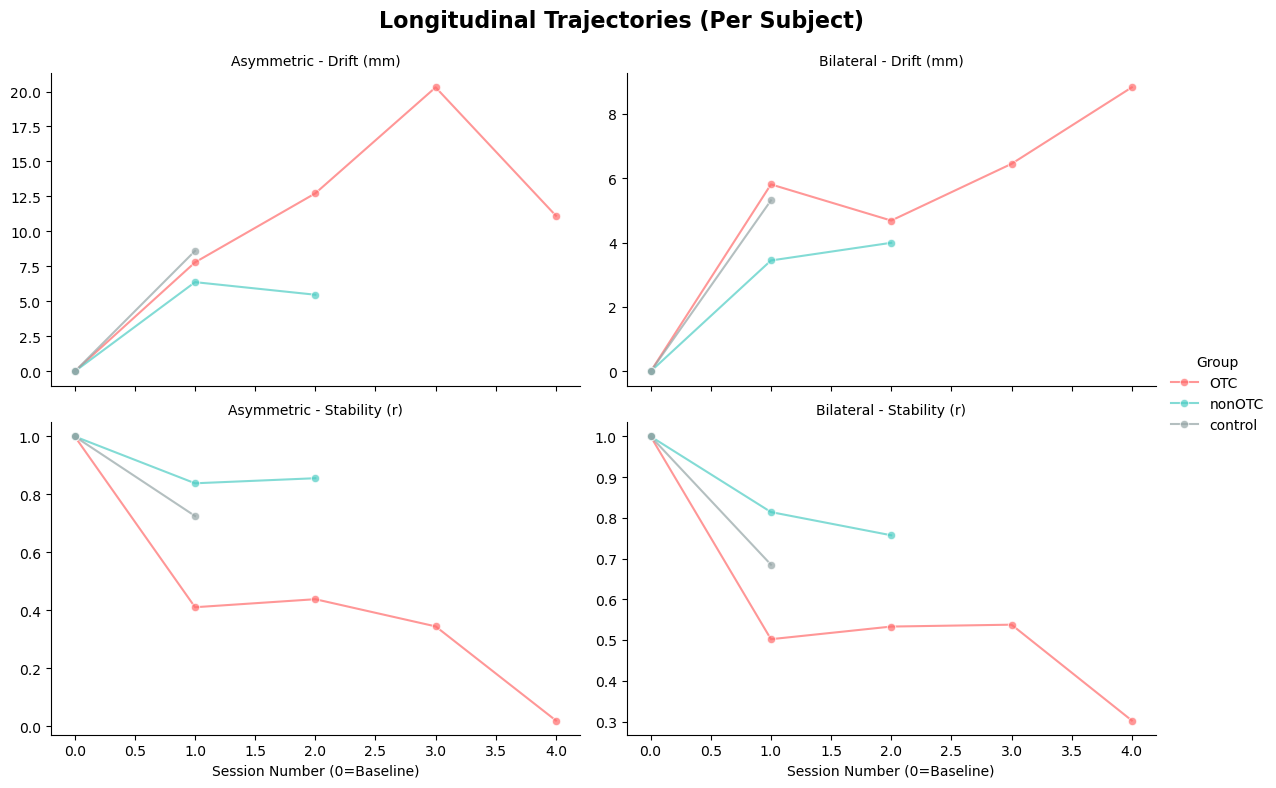

In [ ]:
# CELL 9: Longitudinal Trajectories (Spaghetti Plots)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nibabel as nib

def plot_longitudinal_trajectories(functional_results, subjects, min_voxels=50):
    print("Generating Longitudinal Trajectories...")
    
    # Configurations
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {'face': 'Asymmetric', 'word': 'Asymmetric', 
                      'house': 'Bilateral', 'object': 'Bilateral'}
    
    drift_data = []
    stability_data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        # Get all sessions sorted numerically
        sessions = sorted(list({s for r in res.values() for s in r.keys()}), key=lambda x: int(x))
        if len(sessions) < 2: continue
        
        # Session 1 is the Anchor
        first_ses = sessions[0]
        
        for roi_name, roi_data in res.items():
            cat = roi_name.split('_')[1]
            if first_ses not in roi_data: continue
            
            # Get Anchor ROI
            anchor_mask = roi_data[first_ses]['roi_mask']
            anchor_centroid = np.array(roi_data[first_ses]['centroid'])
            
            # Get Anchor Pattern (for stability)
            if np.sum(anchor_mask) < min_voxels: continue
            
            # Load Anchor Data
            try:
                f = BASE_DIR/sid/f'ses-{first_ses}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'
                z = f/f'cope{EXTRACTION_MAP[cat]}.feat'/'stats'/'zstat1.nii.gz'
                anchor_pattern = nib.load(z).get_fdata()[anchor_mask]
            except: continue

            # Loop through SUBSEQUENT sessions
            for i, current_ses in enumerate(sessions):
                if current_ses == first_ses: 
                    # Plot the 0 point
                    drift_val = 0
                    stab_val = 1.0
                else:
                    if current_ses not in roi_data: continue
                    
                    # --- CALC DRIFT ---
                    if roi_data[current_ses]['n_voxels'] >= min_voxels:
                        curr_centroid = np.array(roi_data[current_ses]['centroid'])
                        drift_val = np.linalg.norm(curr_centroid - anchor_centroid)
                    else: drift_val = np.nan
                        
                    # --- CALC STABILITY ---
                    # Path to current session data (aligned to Ses 1)
                    try:
                        f = BASE_DIR/sid/f'ses-{current_ses}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'
                        z = f/f'cope{EXTRACTION_MAP[cat]}.feat'/'stats'/f'zstat1_ses{first_ses}.nii.gz'
                        curr_pattern = nib.load(z).get_fdata()[anchor_mask]
                        stab_val = np.corrcoef(anchor_pattern, curr_pattern)[0,1]
                    except: stab_val = np.nan

                # Append Data
                common_data = {
                    'Subject': info['code'], 'Group': info['group'],
                    'Category': cat.capitalize(), 'Type': CATEGORY_TYPES.get(cat),
                    'Session_Index': i, 'Session_Label': current_ses
                }
                
                drift_data.append({**common_data, 'Value': drift_val, 'Metric': 'Drift (mm)'})
                stability_data.append({**common_data, 'Value': stab_val, 'Metric': 'Stability (r)'})

    # Combine and Plot
    df_long = pd.DataFrame(drift_data + stability_data)
    
    # Create FacetGrid: Rows = Metric, Cols = Category Type
    g = sns.FacetGrid(df_long, row="Metric", col="Type", hue="Group", 
                      palette={'OTC': '#ff6b6b', 'nonOTC': '#4ecdc4', 'control': '#95a5a6'},
                      height=4, aspect=1.5, sharey=False)
    
    g.map(sns.lineplot, "Session_Index", "Value", alpha=0.7, marker="o", errorbar=None)
    
    # Add titles and clean up
    g.set_titles("{col_name} - {row_name}")
    g.set_axis_labels("Session Number (0=Baseline)", "")
    g.add_legend()
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Longitudinal Trajectories (Per Subject)", fontsize=16, fontweight='bold')
    plt.show()
    
    return df_long

df_traj = plot_longitudinal_trajectories(golarai_functional_final, ANALYSIS_SUBJECTS)

Generating Individual Subject Trajectories...


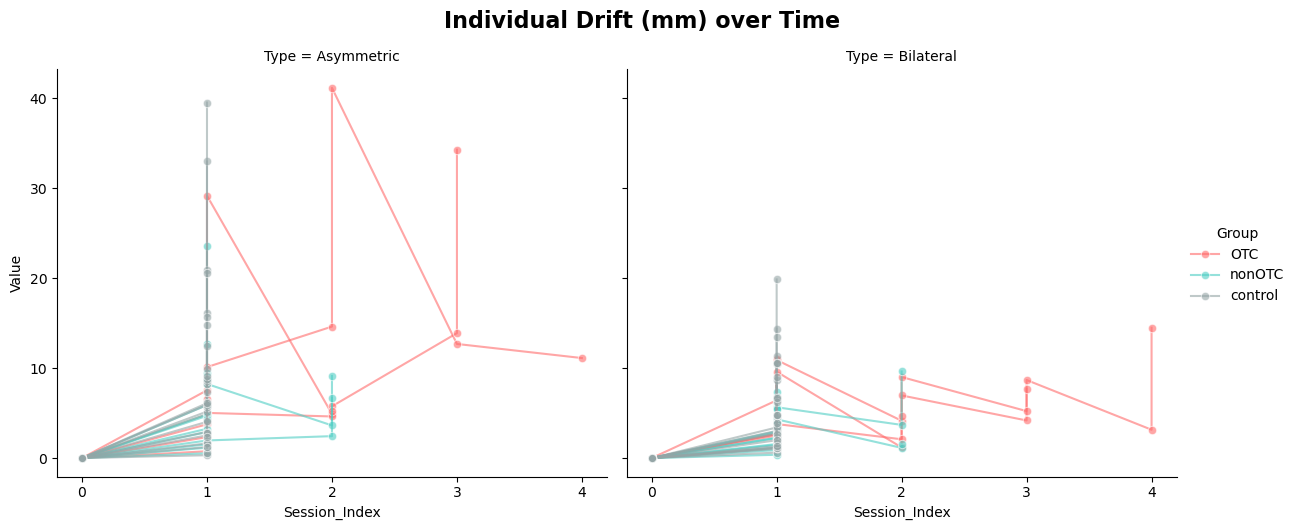

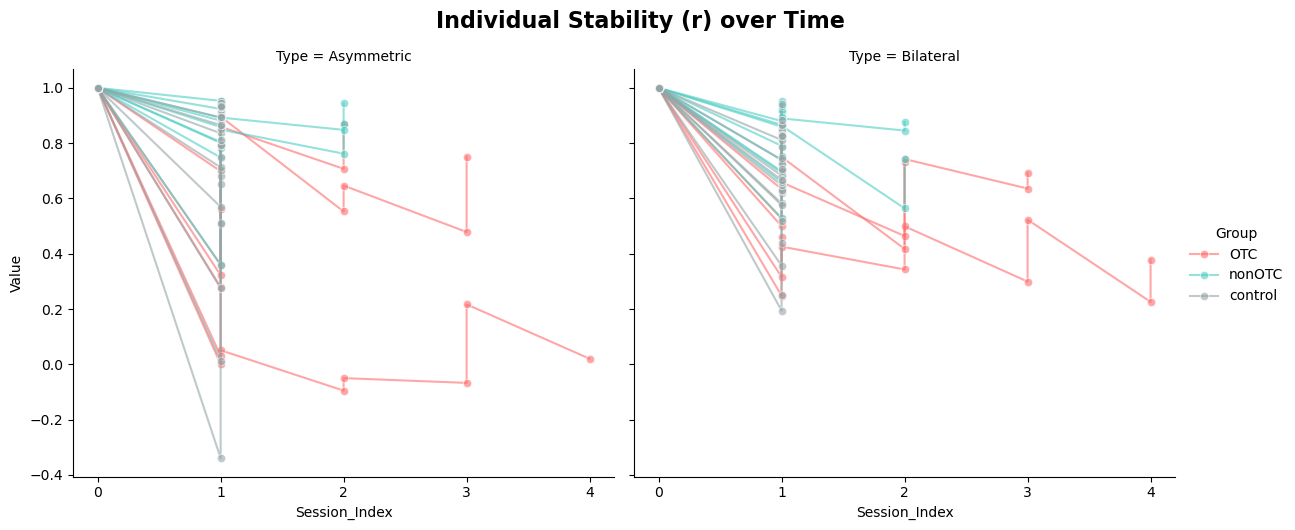

In [10]:
# CELL 10: Individual Subject Trajectories (Fixed)
def plot_individual_trajectories(df_long):
    print("Generating Individual Subject Trajectories...")
    
    # Filter for the metrics we care about
    metrics = ['Drift (mm)', 'Stability (r)']
    
    for metric in metrics:
        # Initialize the Grid
        g = sns.FacetGrid(df_long[df_long['Metric'] == metric], 
                          col="Type", hue="Group", 
                          palette={'OTC': '#ff6b6b', 'nonOTC': '#4ecdc4', 'control': '#95a5a6'},
                          height=5, aspect=1.2)
        
        # FIX: Use map_dataframe to explicitly handle 'units'
        g.map_dataframe(sns.lineplot, 
                        x="Session_Index", 
                        y="Value", 
                        units="Subject", # <--- This draws one line per subject
                        estimator=None,  # <--- This prevents averaging
                        alpha=0.6, 
                        linewidth=1.5, 
                        marker="o")
        
        g.add_legend()
        g.fig.suptitle(f"Individual {metric} over Time", y=1.05, fontsize=16, fontweight='bold')
        
        # Fix X-axis to show integers
        for ax in g.axes.flat:
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            
        plt.show()

# Run with the dataframe from Cell 9
if 'df_traj' in locals():
    plot_individual_trajectories(df_traj)
else:
    print("⚠️ df_traj not found. Please run Cell 9 first.")

In [11]:
# CELL 11: Data Audit (Subject & Session Availability)
def audit_functional_data(functional_results, subjects):
    print("\n" + "="*80)
    print("FUNCTIONAL DATA AUDIT: Which sessions survived extraction?")
    print("="*80)
    
    print(f"{'Subject':<10} {'Group':<8} {'Category':<10} {'Sessions Found'}")
    print("-" * 60)
    
    # Track missing sessions for specific interest
    missing_log = []

    for subject_id in sorted(subjects.keys()):
        info = subjects[subject_id]
        code = info['code']
        group = info['group']
        
        # Check if subject exists in results
        if subject_id not in functional_results:
            print(f"{code:<10} {group:<8} -- NO DATA EXTRACTED --")
            continue
            
        res = functional_results[subject_id]
        
        # Check each category
        # We define the "Expected" sessions based on the directory structure
        # (This requires a quick look at the filesystem or just assuming based on gaps)
        
        for cat in ['face', 'word', 'house', 'object']:
            # Find the key (l_face or r_face)
            found_key = None
            for key in res.keys():
                if key.endswith(f"_{cat}"):
                    found_key = key
                    break
            
            if found_key:
                sessions = sorted(res[found_key].keys())
                sess_str = ", ".join(sessions)
                print(f"{code:<10} {group:<8} {cat:<10} {sess_str}")
                
                # Specific check for OTC079
                if code == 'OTC079' and '2' not in sessions:
                    missing_log.append(f"OTC079: Missing Ses-02 for {cat}")
            else:
                # ROI completely failed (size < 30 for all sessions)
                print(f"{code:<10} {group:<8} {cat:<10} [DROP] No valid ROIs > 30 voxels")

    print("\n" + "="*80)
    print("SPECIFIC ALERTS")
    print("="*80)
    if missing_log:
        for msg in missing_log:
            print(f"⚠️ {msg}")
    else:
        print("No specific alerts triggered.")

audit_functional_data(golarai_functional_final, ANALYSIS_SUBJECTS)


FUNCTIONAL DATA AUDIT: Which sessions survived extraction?
Subject    Group    Category   Sessions Found
------------------------------------------------------------
OTC004     OTC      face       01, 02, 03, 05, 06
OTC004     OTC      word       01, 02, 03, 05
OTC004     OTC      house      01, 02, 03, 05, 06
OTC004     OTC      object     01, 02, 03, 05, 06
nonOTC007  nonOTC   face       01, 03, 04
nonOTC007  nonOTC   word       01, 03, 04
nonOTC007  nonOTC   house      01, 03, 04
nonOTC007  nonOTC   object     01, 03, 04
OTC008     OTC      face       01, 02
OTC008     OTC      word       01, 02
OTC008     OTC      house      01, 02
OTC008     OTC      object     01, 02
OTC010     OTC      face       02, 03
OTC010     OTC      word       03
OTC010     OTC      house      02, 03
OTC010     OTC      object     02, 03
OTC017     OTC      face       01, 02, 03, 04
OTC017     OTC      word       01, 02, 03, 04
OTC017     OTC      house      01, 02, 03, 04
OTC017     OTC      object     

In [12]:
# CELL 12: Statistical Significance Testing (With N and SD)
from scipy import stats
import pandas as pd

def run_stats(df, metric_name, measure_col):
    print(f"\n{'='*90}")
    print(f"STATISTICS FOR: {metric_name}")
    print(f"{'='*90}")
    
    groups = ['OTC', 'control'] 
    types = ['Asymmetric', 'Bilateral']
    
    # Helper to get data
    def get_data(grp, typ):
        return df[(df['Group'] == grp) & (df['Type'] == typ)][measure_col].dropna()

    # --- TEST 1: DEFICIT (OTC Asym vs Control Asym) ---
    d1 = get_data('OTC', 'Asymmetric')
    d2 = get_data('control', 'Asymmetric')
    
    t, p = stats.ttest_ind(d1, d2, equal_var=False)
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    
    print(f"1. DEFICIT TEST (OTC Asym vs. Control Asym):")
    print(f"   OTC     : N={len(d1):<3} | Mean={d1.mean():.3f} | SD={d1.std():.3f}")
    print(f"   Control : N={len(d2):<3} | Mean={d2.mean():.3f} | SD={d2.std():.3f}")
    print(f"   Result  : T={t:.3f} | p={p:.4f}  [{sig}]")
    
    # --- TEST 2: DISSOCIATION (OTC Asym vs OTC Bilat) ---
    d1 = get_data('OTC', 'Asymmetric')
    d2 = get_data('OTC', 'Bilateral')
    
    t, p = stats.ttest_ind(d1, d2, equal_var=False)
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    
    print(f"\n2. DISSOCIATION TEST (OTC Asym vs. OTC Bilat):")
    print(f"   OTC Asym : N={len(d1):<3} | Mean={d1.mean():.3f} | SD={d1.std():.3f}")
    print(f"   OTC Bilat: N={len(d2):<3} | Mean={d2.mean():.3f} | SD={d2.std():.3f}")
    print(f"   Result   : T={t:.3f} | p={p:.4f}  [{sig}]")

    # --- TEST 3: CROWDING CHECK (OTC Bilat vs Control Bilat) ---
    d1 = get_data('OTC', 'Bilateral')
    d2 = get_data('control', 'Bilateral')
    
    t, p = stats.ttest_ind(d1, d2, equal_var=False)
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    
    print(f"\n3. CROWDING CHECK (OTC Bilat vs. Control Bilat):")
    print(f"   OTC     : N={len(d1):<3} | Mean={d1.mean():.3f} | SD={d1.std():.3f}")
    print(f"   Control : N={len(d2):<3} | Mean={d2.mean():.3f} | SD={d2.std():.3f}")
    print(f"   Result  : T={t:.3f} | p={p:.4f}  [{sig}]")

# Execute
if 'df_hybrid' in locals(): run_stats(df_hybrid, "HYBRID STABILITY (Local Anchor)", 'Stability (r)')
if 'df_drift' in locals(): run_stats(df_drift, "DRIFT (Physical Movement)", 'Drift (mm)')
if 'df_rdm' in locals(): run_stats(df_rdm, "RDM STABILITY (Geometry)", 'RDM Stability (r)')


STATISTICS FOR: HYBRID STABILITY (Local Anchor)
1. DEFICIT TEST (OTC Asym vs. Control Asym):
   OTC     : N=9   | Mean=0.414 | SD=0.336
   Control : N=34  | Mean=0.726 | SD=0.284
   Result  : T=-2.551 | p=0.0266  [*]

2. DISSOCIATION TEST (OTC Asym vs. OTC Bilat):
   OTC Asym : N=9   | Mean=0.414 | SD=0.336
   OTC Bilat: N=9   | Mean=0.480 | SD=0.183
   Result   : T=-0.517 | p=0.6143  [ns]

3. CROWDING CHECK (OTC Bilat vs. Control Bilat):
   OTC     : N=9   | Mean=0.480 | SD=0.183
   Control : N=36  | Mean=0.685 | SD=0.169
   Result  : T=-3.052 | p=0.0103  [*]

STATISTICS FOR: DRIFT (Physical Movement)
1. DEFICIT TEST (OTC Asym vs. Control Asym):
   OTC     : N=8   | Mean=10.232 | SD=10.472
   Control : N=34  | Mean=9.447 | SD=10.201
   Result  : T=0.192 | p=0.8516  [ns]

2. DISSOCIATION TEST (OTC Asym vs. OTC Bilat):
   OTC Asym : N=8   | Mean=10.232 | SD=10.472
   OTC Bilat: N=9   | Mean=6.386 | SD=4.119
   Result   : T=0.974 | p=0.3558  [ns]

3. CROWDING CHECK (OTC Bilat vs. Contro

Generating Master Publication Figure...


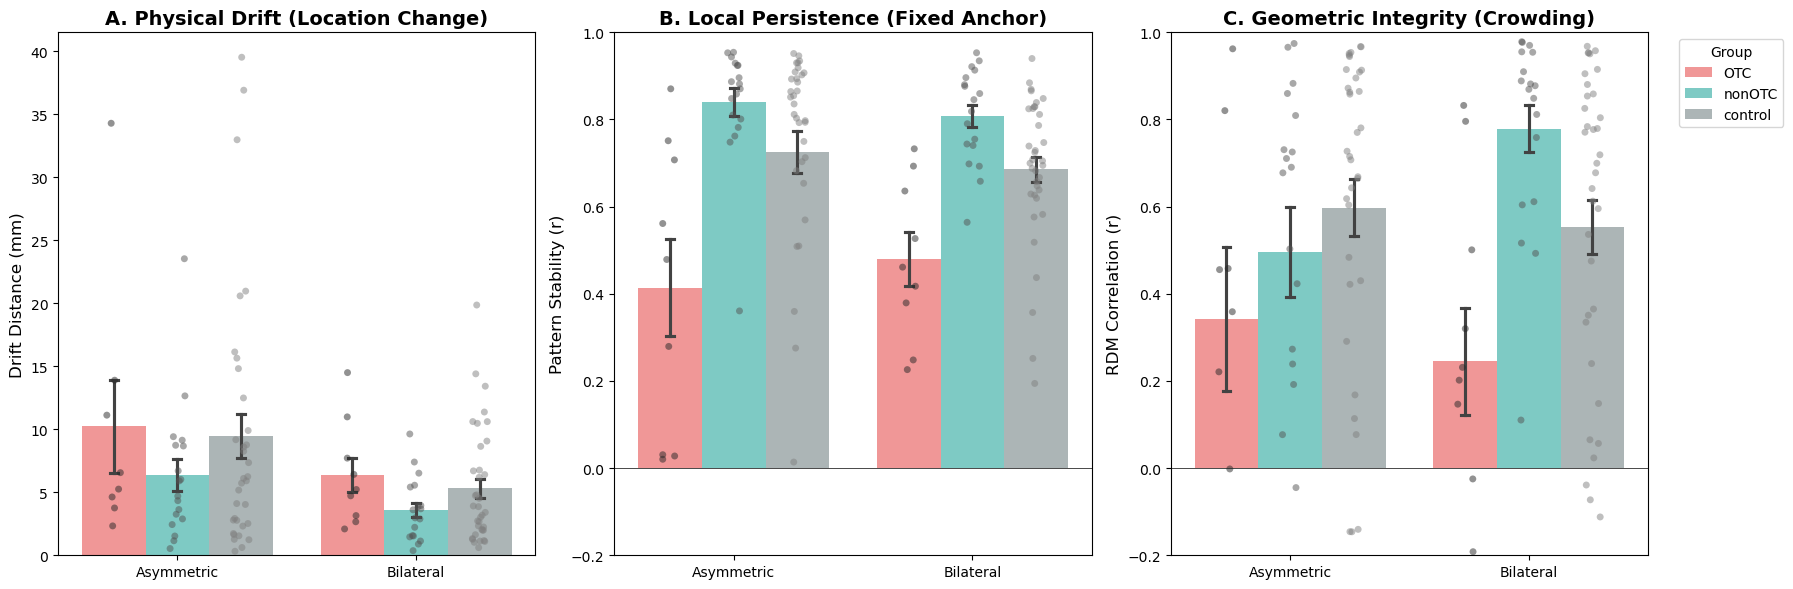

In [13]:
# CELL 20: Master Publication Figure (Drift, Hybrid, RDM)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_master_figure(df_drift, df_hybrid, df_rdm):
    print("Generating Master Publication Figure...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Shared Plot Settings
    pal = {'OTC': '#ff6b6b', 'nonOTC': '#4ecdc4', 'control': '#95a5a6'}
    order = ['Asymmetric', 'Bilateral']
    
    # --- PANEL A: DRIFT (Physical Movement) ---
    sns.barplot(data=df_drift, x='Type', y='Drift (mm)', hue='Group', 
                palette=pal, alpha=0.8, ax=axes[0], order=order, errorbar='se', capsize=0.1)
    # Add Stripplot for individual points
    sns.stripplot(data=df_drift, x='Type', y='Drift (mm)', hue='Group', 
                  dodge=True, palette='dark:gray', alpha=0.5, legend=False, ax=axes[0], order=order)
    
    axes[0].set_title("A. Physical Drift (Location Change)", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Drift Distance (mm)", fontsize=12)
    axes[0].set_xlabel("")
    axes[0].legend_.remove() # Clean up legends
    
    # --- PANEL B: HYBRID STABILITY (Local Anchor) ---
    sns.barplot(data=df_hybrid, x='Type', y='Stability (r)', hue='Group', 
                palette=pal, alpha=0.8, ax=axes[1], order=order, errorbar='se', capsize=0.1)
    sns.stripplot(data=df_hybrid, x='Type', y='Stability (r)', hue='Group', 
                  dodge=True, palette='dark:gray', alpha=0.5, legend=False, ax=axes[1], order=order)
    
    axes[1].set_title("B. Local Persistence (Fixed Anchor)", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("Pattern Stability (r)", fontsize=12)
    axes[1].set_xlabel("")
    axes[1].set_ylim(-0.2, 1.0)
    axes[1].axhline(0, color='black', linewidth=0.5)
    axes[1].legend_.remove()

    # --- PANEL C: RDM STABILITY (Geometry) ---
    sns.barplot(data=df_rdm, x='Type', y='RDM Stability (r)', hue='Group', 
                palette=pal, alpha=0.8, ax=axes[2], order=order, errorbar='se', capsize=0.1)
    sns.stripplot(data=df_rdm, x='Type', y='RDM Stability (r)', hue='Group', 
                  dodge=True, palette='dark:gray', alpha=0.5, legend=False, ax=axes[2], order=order)
    
    axes[2].set_title("C. Geometric Integrity (Crowding)", fontsize=14, fontweight='bold')
    axes[2].set_ylabel("RDM Correlation (r)", fontsize=12)
    axes[2].set_xlabel("")
    axes[2].set_ylim(-0.2, 1.0)
    axes[2].axhline(0, color='black', linewidth=0.5)
    
    # Clean up the legend
    handles, labels = axes[2].get_legend_handles_labels()
    # We only want the first 3 handles (Groups), not the strip plot points
    axes[2].legend(handles[:3], labels[:3], title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Execute only if dataframes exist
if 'df_drift' in locals() and 'df_hybrid' in locals() and 'df_rdm' in locals():
    plot_master_figure(df_drift, df_hybrid, df_rdm)
else:
    print("Missing dataframes. Please run extraction cells first.")

In [14]:
# CELL: Add Statistics to Existing Analyses
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu, permutation_test
import pandas as pd
import numpy as np

def compute_statistics_for_analyses(df_hybrid, df_drift, df_rdm, analysis_subjects):
    """
    Add proper statistics to all three main analyses:
    - Cell 5: Hybrid stability (fixed ROI)
    - Cell 6: Spatial drift
    - Cell 7: RDM stability (dynamic ROI)
    """
    
    print("="*70)
    print("STATISTICAL ANALYSIS: CELLS 5, 6, 7")
    print("="*70)
    
    results = {}
    
    # ========== CELL 5: HYBRID STABILITY ==========
    if not df_hybrid.empty:
        print("\n" + "="*70)
        print("CELL 5: HYBRID STABILITY (Fixed ROI Pattern Correlation)")
        print("="*70)
        
        # OTC vs Controls - Asymmetric
        otc_asym = df_hybrid[(df_hybrid['Group'] == 'OTC') & (df_hybrid['Type'] == 'Asymmetric')]['Stability (r)']
        ctrl_asym = df_hybrid[(df_hybrid['Group'] == 'control') & (df_hybrid['Type'] == 'Asymmetric')]['Stability (r)']
        
        if len(otc_asym) > 0 and len(ctrl_asym) > 0:
            t_stat, p_val = ttest_ind(otc_asym, ctrl_asym)
            d = (np.mean(otc_asym) - np.mean(ctrl_asym)) / np.sqrt((np.std(otc_asym)**2 + np.std(ctrl_asym)**2) / 2)
            print(f"\nAsymmetric: OTC vs Controls")
            print(f"  OTC: M={np.mean(otc_asym):.3f}, SD={np.std(otc_asym):.3f}, N={len(otc_asym)}")
            print(f"  Controls: M={np.mean(ctrl_asym):.3f}, SD={np.std(ctrl_asym):.3f}, N={len(ctrl_asym)}")
            print(f"  t({len(otc_asym)+len(ctrl_asym)-2})={t_stat:.2f}, p={p_val:.4f}, d={d:.2f}")
        
        # OTC vs Controls - Bilateral
        otc_bil = df_hybrid[(df_hybrid['Group'] == 'OTC') & (df_hybrid['Type'] == 'Bilateral')]['Stability (r)']
        ctrl_bil = df_hybrid[(df_hybrid['Group'] == 'control') & (df_hybrid['Type'] == 'Bilateral')]['Stability (r)']
        
        if len(otc_bil) > 0 and len(ctrl_bil) > 0:
            t_stat, p_val = ttest_ind(otc_bil, ctrl_bil)
            d = (np.mean(otc_bil) - np.mean(ctrl_bil)) / np.sqrt((np.std(otc_bil)**2 + np.std(ctrl_bil)**2) / 2)
            print(f"\nBilateral: OTC vs Controls")
            print(f"  OTC: M={np.mean(otc_bil):.3f}, SD={np.std(otc_bil):.3f}, N={len(otc_bil)}")
            print(f"  Controls: M={np.mean(ctrl_bil):.3f}, SD={np.std(ctrl_bil):.3f}, N={len(ctrl_bil)}")
            print(f"  t({len(otc_bil)+len(ctrl_bil)-2})={t_stat:.2f}, p={p_val:.4f}, d={d:.2f}")
        
        # Within OTC: Asymmetric vs Bilateral
        if len(otc_asym) > 0 and len(otc_bil) > 0:
            t_stat, p_val = ttest_ind(otc_asym, otc_bil)
            d = (np.mean(otc_asym) - np.mean(otc_bil)) / np.sqrt((np.std(otc_asym)**2 + np.std(otc_bil)**2) / 2)
            print(f"\nWithin OTC: Asymmetric vs Bilateral")
            print(f"  Asymmetric: M={np.mean(otc_asym):.3f}")
            print(f"  Bilateral: M={np.mean(otc_bil):.3f}")
            print(f"  t({len(otc_asym)+len(otc_bil)-2})={t_stat:.2f}, p={p_val:.4f}, d={d:.2f}")
    
    # ========== CELL 6: SPATIAL DRIFT ==========
    if not df_drift.empty:
        print("\n" + "="*70)
        print("CELL 6: SPATIAL DRIFT")
        print("="*70)
        
        # OTC: Asymmetric vs Bilateral
        otc_drift = df_drift[df_drift['Group'] == 'OTC']
        otc_asym_drift = otc_drift[otc_drift['Type'] == 'Asymmetric']['Drift (mm)']
        otc_bil_drift = otc_drift[otc_drift['Type'] == 'Bilateral']['Drift (mm)']
        
        if len(otc_asym_drift) > 0 and len(otc_bil_drift) > 0:
            t_stat, p_val = ttest_ind(otc_asym_drift, otc_bil_drift)
            d = (np.mean(otc_asym_drift) - np.mean(otc_bil_drift)) / np.sqrt((np.std(otc_asym_drift)**2 + np.std(otc_bil_drift)**2) / 2)
            print(f"\nOTC: Asymmetric vs Bilateral Drift")
            print(f"  Asymmetric: M={np.mean(otc_asym_drift):.2f}mm, SD={np.std(otc_asym_drift):.2f}, N={len(otc_asym_drift)}")
            print(f"  Bilateral: M={np.mean(otc_bil_drift):.2f}mm, SD={np.std(otc_bil_drift):.2f}, N={len(otc_bil_drift)}")
            print(f"  t({len(otc_asym_drift)+len(otc_bil_drift)-2})={t_stat:.2f}, p={p_val:.4f}, d={d:.2f}")
            
            if p_val < 0.05:
                print(f"  ✓ SIGNIFICANT: Asymmetric drifts MORE than bilateral")
    
    # ========== CELL 7: RDM STABILITY ==========
    if not df_rdm.empty:
        print("\n" + "="*70)
        print("CELL 7: RDM STABILITY (Representational Geometry)")
        print("="*70)
        
        # OTC: Asymmetric vs Bilateral
        otc_rdm = df_rdm[df_rdm['Group'] == 'OTC']
        otc_asym_rdm = otc_rdm[otc_rdm['Type'] == 'Asymmetric']['RDM Stability (r)']
        otc_bil_rdm = otc_rdm[otc_rdm['Type'] == 'Bilateral']['RDM Stability (r)']
        
        if len(otc_asym_rdm) > 0 and len(otc_bil_rdm) > 0:
            t_stat, p_val = ttest_ind(otc_asym_rdm, otc_bil_rdm)
            d = (np.mean(otc_asym_rdm) - np.mean(otc_bil_rdm)) / np.sqrt((np.std(otc_asym_rdm)**2 + np.std(otc_bil_rdm)**2) / 2)
            print(f"\nOTC: Asymmetric vs Bilateral RDM Stability")
            print(f"  Asymmetric: M={np.mean(otc_asym_rdm):.3f}, SD={np.std(otc_asym_rdm):.3f}, N={len(otc_asym_rdm)}")
            print(f"  Bilateral: M={np.mean(otc_bil_rdm):.3f}, SD={np.std(otc_bil_rdm):.3f}, N={len(otc_bil_rdm)}")
            print(f"  t({len(otc_asym_rdm)+len(otc_bil_rdm)-2})={t_stat:.2f}, p={p_val:.4f}, d={d:.2f}")
            
            if p_val < 0.05:
                print(f"  ✓ SIGNIFICANT: Bilateral shows LOWER stability (more reorganization)")
        
        # OTC vs Controls - Bilateral
        ctrl_bil_rdm = df_rdm[(df_rdm['Group'] == 'control') & (df_rdm['Type'] == 'Bilateral')]['RDM Stability (r)']
        
        if len(otc_bil_rdm) > 0 and len(ctrl_bil_rdm) > 0:
            t_stat, p_val = ttest_ind(otc_bil_rdm, ctrl_bil_rdm)
            d = (np.mean(otc_bil_rdm) - np.mean(ctrl_bil_rdm)) / np.sqrt((np.std(otc_bil_rdm)**2 + np.std(ctrl_bil_rdm)**2) / 2)
            print(f"\nBilateral: OTC vs Controls")
            print(f"  OTC: M={np.mean(otc_bil_rdm):.3f}, SD={np.std(otc_bil_rdm):.3f}, N={len(otc_bil_rdm)}")
            print(f"  Controls: M={np.mean(ctrl_bil_rdm):.3f}, SD={np.std(ctrl_bil_rdm):.3f}, N={len(ctrl_bil_rdm)}")
            print(f"  t({len(otc_bil_rdm)+len(ctrl_bil_rdm)-2})={t_stat:.2f}, p={p_val:.4f}, d={d:.2f}")
    
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY COMPLETE")
    print("="*70)
    print("\nNOTE: With small N and heterogeneity, interpret with caution.")
    print("Consider bootstrapping or permutation tests for robustness.")
    
    return results

# Run statistics
stats_results = compute_statistics_for_analyses(df_hybrid, df_drift, df_rdm, ANALYSIS_SUBJECTS)

STATISTICAL ANALYSIS: CELLS 5, 6, 7

CELL 5: HYBRID STABILITY (Fixed ROI Pattern Correlation)

Asymmetric: OTC vs Controls
  OTC: M=0.414, SD=0.317, N=9
  Controls: M=0.726, SD=0.280, N=34
  t(41)=-2.82, p=0.0074, d=-1.04

Bilateral: OTC vs Controls
  OTC: M=0.480, SD=0.173, N=9
  Controls: M=0.685, SD=0.167, N=36
  t(43)=-3.20, p=0.0026, d=-1.21

Within OTC: Asymmetric vs Bilateral
  Asymmetric: M=0.414
  Bilateral: M=0.480
  t(16)=-0.52, p=0.6123, d=-0.26

CELL 6: SPATIAL DRIFT

OTC: Asymmetric vs Bilateral Drift
  Asymmetric: M=10.23mm, SD=9.80, N=8
  Bilateral: M=6.39mm, SD=3.88, N=9
  t(15)=1.02, p=0.3239, d=0.52

CELL 7: RDM STABILITY (Representational Geometry)

OTC: Asymmetric vs Bilateral RDM Stability
  Asymmetric: M=0.343, SD=0.438, N=8
  Bilateral: M=0.245, SD=0.370, N=10
  t(16)=0.48, p=0.6343, d=0.24

Bilateral: OTC vs Controls
  OTC: M=0.245, SD=0.370, N=10
  Controls: M=0.553, SD=0.369, N=36
  t(44)=-2.29, p=0.0269, d=-0.84

STATISTICAL SUMMARY COMPLETE

NOTE: With smal

In [15]:
# CELL: Bootstrap & Permutation Statistics
import numpy as np
from scipy import stats
import pandas as pd

def bootstrap_case_series(df, n_boot=10000):
    """Bootstrap confidence intervals for heterogeneous case data"""
    
    results = {}
    
    for group in ['OTC', 'nonOTC', 'control']:
        for cat_type in ['Asymmetric', 'Bilateral']:
            data = df[(df['Group'] == group) & (df['Type'] == cat_type)]['Stability (r)'].values
            
            if len(data) < 3:
                continue
            
            # Bootstrap individual subjects with replacement
            boot_means = []
            for _ in range(n_boot):
                # Resample subjects, not observations
                subjects = df[(df['Group'] == group) & (df['Type'] == cat_type)]['Subject'].unique()
                boot_subjects = np.random.choice(subjects, size=len(subjects), replace=True)
                
                boot_data = []
                for subj in boot_subjects:
                    subj_data = df[(df['Subject'] == subj) & (df['Type'] == cat_type)]['Stability (r)'].values
                    if len(subj_data) > 0:
                        boot_data.extend(subj_data)
                
                if boot_data:
                    boot_means.append(np.mean(boot_data))
            
            if boot_means:
                results[f"{group}_{cat_type}"] = {
                    'mean': np.mean(data),
                    'CI_2.5': np.percentile(boot_means, 2.5),
                    'CI_97.5': np.percentile(boot_means, 97.5),
                    'SE': np.std(boot_means)
                }
    
    return results

def permutation_test_cases(df, group1='OTC', group2='control', n_perm=10000):
    """Permutation test for case-control differences"""
    
    results = {}
    
    for cat_type in ['Asymmetric', 'Bilateral']:
        g1_data = df[(df['Group'] == group1) & (df['Type'] == cat_type)]['Stability (r)'].values
        g2_data = df[(df['Group'] == group2) & (df['Type'] == cat_type)]['Stability (r)'].values
        
        if len(g1_data) < 2 or len(g2_data) < 2:
            continue
        
        obs_diff = np.mean(g1_data) - np.mean(g2_data)
        combined = np.concatenate([g1_data, g2_data])
        
        perm_diffs = []
        for _ in range(n_perm):
            np.random.shuffle(combined)
            perm_g1 = combined[:len(g1_data)]
            perm_g2 = combined[len(g1_data):]
            perm_diffs.append(np.mean(perm_g1) - np.mean(perm_g2))
        
        p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
        
        results[cat_type] = {
            'observed_diff': obs_diff,
            'p_value': p_value,
            'effect_size': obs_diff / np.std(combined)
        }
    
    return results

# Run analyses
boot_results = bootstrap_case_series(df_hybrid)
perm_results = permutation_test_cases(df_hybrid)

print("BOOTSTRAP 95% CIs:")
for key, vals in boot_results.items():
    print(f"{key}: {vals['mean']:.3f} [{vals['CI_2.5']:.3f}, {vals['CI_97.5']:.3f}]")

print("\nPERMUTATION TESTS (OTC vs Control):")
for cat, vals in perm_results.items():
    print(f"{cat}: diff={vals['observed_diff']:.3f}, p={vals['p_value']:.4f}")

BOOTSTRAP 95% CIs:
OTC_Asymmetric: 0.414 [0.156, 0.655]
OTC_Bilateral: 0.480 [0.351, 0.609]
nonOTC_Asymmetric: 0.841 [0.763, 0.900]
nonOTC_Bilateral: 0.808 [0.756, 0.856]
control_Asymmetric: 0.726 [0.614, 0.828]
control_Bilateral: 0.685 [0.592, 0.766]

PERMUTATION TESTS (OTC vs Control):
Asymmetric: diff=-0.311, p=0.0069
Bilateral: diff=-0.205, p=0.0030


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


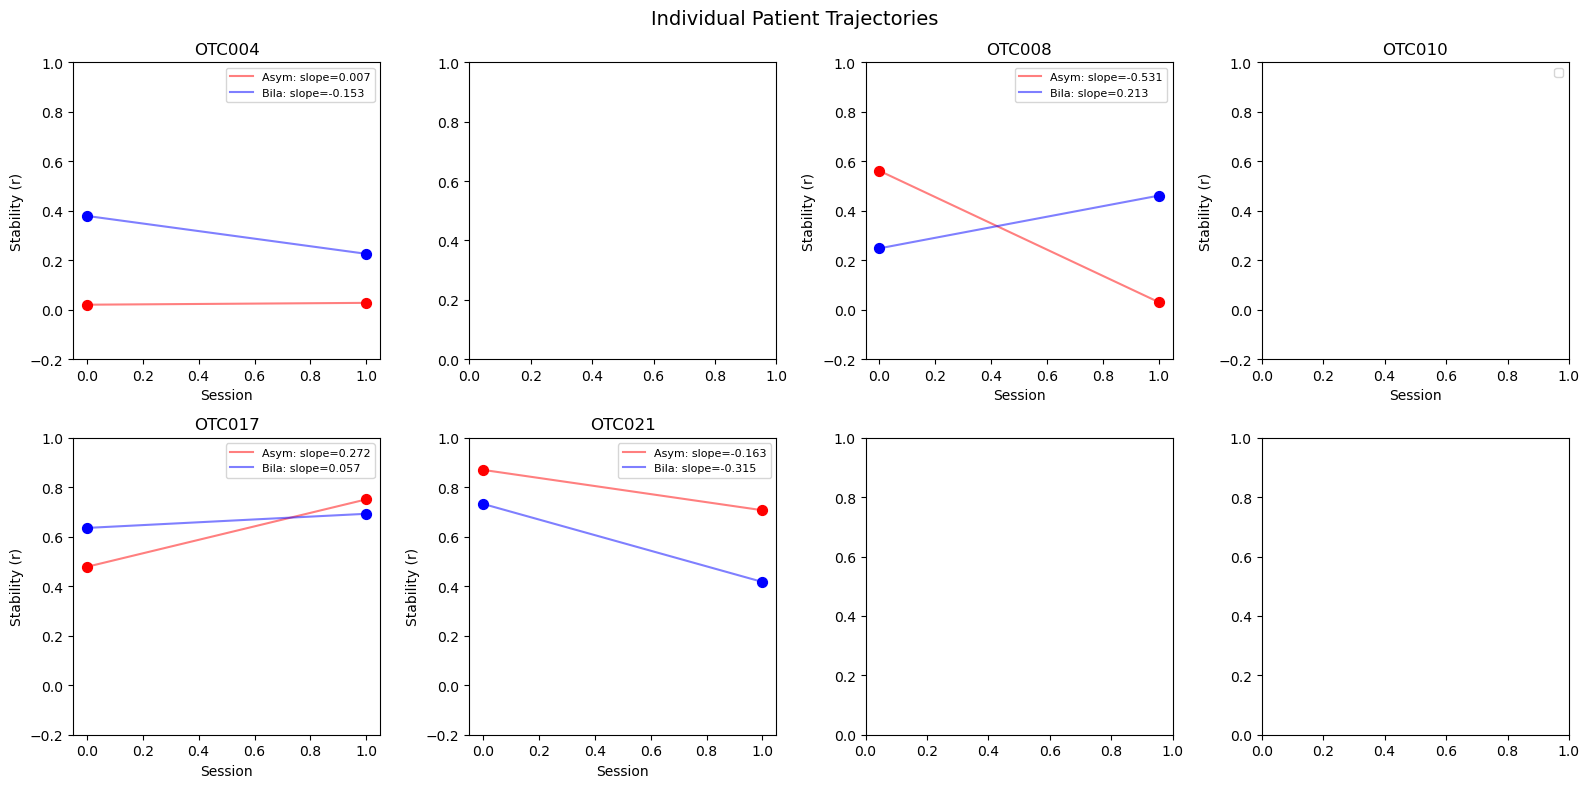


INDIVIDUAL TRAJECTORY SLOPES:
Type     Asymmetric  Bilateral
Subject                       
OTC004     0.007449  -0.153076
OTC008    -0.530587   0.212936
OTC017     0.272477   0.057105
OTC021    -0.163087  -0.315231


In [16]:
# CELL: Individual Trajectory Modeling
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def model_individual_trajectories(functional_results, subjects, df_hybrid):
    """Model each patient's trajectory separately"""
    
    individual_slopes = []
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (sid, info) in enumerate(list(subjects.items())[:8]):
        if info['group'] != 'OTC':
            continue
            
        # Get this subject's data across sessions
        subj_data = df_hybrid[df_hybrid['Subject'] == info['code']]
        
        if len(subj_data) < 2:
            continue
            
        ax = axes[idx]
        
        for cat_type, color in [('Asymmetric', 'red'), ('Bilateral', 'blue')]:
            type_data = subj_data[subj_data['Type'] == cat_type]
            
            if len(type_data) > 1:
                # Simple linear model per category
                X = np.arange(len(type_data)).reshape(-1, 1)
                y = type_data['Stability (r)'].values
                
                model = LinearRegression()
                model.fit(X, y)
                slope = model.coef_[0]
                
                ax.scatter(X, y, color=color, s=50)
                ax.plot(X, model.predict(X), color=color, alpha=0.5, 
                       label=f"{cat_type[:4]}: slope={slope:.3f}")
                
                individual_slopes.append({
                    'Subject': info['code'],
                    'Type': cat_type,
                    'Slope': slope,
                    'N_sessions': len(type_data)
                })
        
        ax.set_title(f"{info['code']}")
        ax.set_ylabel("Stability (r)")
        ax.set_xlabel("Session")
        ax.legend(fontsize=8)
        ax.set_ylim(-0.2, 1.0)
    
    plt.suptitle("Individual Patient Trajectories", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Summary of slopes
    slopes_df = pd.DataFrame(individual_slopes)
    print("\nINDIVIDUAL TRAJECTORY SLOPES:")
    print(slopes_df.pivot(index='Subject', columns='Type', values='Slope'))
    
    return slopes_df

slopes = model_individual_trajectories(golarai_functional_final, ANALYSIS_SUBJECTS, df_hybrid)

In [17]:
# CELL: Hierarchical Linear Model
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

def hierarchical_model(df_traj):
    """Mixed-effects model accounting for within-subject correlation"""
    
    # Prepare data
    model_data = df_traj[df_traj['Group'] == 'OTC'].copy()
    model_data['Session_Num'] = model_data['Session_Index']
    model_data['Is_Bilateral'] = (model_data['Type'] == 'Bilateral').astype(int)
    
    # Mixed model: Value ~ Session + Type + (1|Subject)
    model = MixedLM.from_formula(
        'Value ~ Session_Num * Is_Bilateral', 
        model_data[model_data['Metric'] == 'Stability (r)'],
        groups=model_data[model_data['Metric'] == 'Stability (r)']['Subject']
    )
    
    result = model.fit()
    print(result.summary())
    
    return result

# Run if longitudinal data exists
if 'df_traj' in locals():
    hlm_result = hierarchical_model(df_traj)

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Value  
No. Observations:       59          Method:                 REML   
No. Groups:             5           Scale:                  0.0592 
Min. group size:        4           Log-Likelihood:         -9.8583
Max. group size:        19          Converged:              Yes    
Mean group size:        11.8                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.842    0.087  9.656 0.000  0.671  1.012
Session_Num              -0.211    0.041 -5.143 0.000 -0.291 -0.131
Is_Bilateral             -0.001    0.095 -0.010 0.992 -0.187  0.185
Session_Num:Is_Bilateral  0.071    0.054  1.314 0.189 -0.035  0.176
Group Var                 0.015    0.057                       

In [18]:
# CELL 24: Generate Detailed Category Table (Group x Hemi x Category)
import pandas as pd
import numpy as np

def generate_detailed_marlene_table(df_drift, df_hybrid, df_rdm, subjects):
    print("Generating Detailed Category Breakdown...")
    
    # 1. Helper to define "Hemisphere" logic
    def get_hemi_label(row):
        code = row['Subject']
        # Find subject info
        for sid, info in subjects.items():
            if info['code'] == code:
                if info['group'] == 'control':
                    return "Control (Both)" # Controls use both hemis
                elif info['group'] == 'OTC':
                    # Return the PRESERVED hemisphere
                    return f"OTC {info['hemi'].upper()} (Preserved)"
                elif info['group'] == 'nonOTC':
                    return f"nonOTC {info['hemi'].upper()} (Preserved)"
        return "Unknown"

    # 2. Process Dataframes
    # We create a unified list of metrics to merge later
    dfs_to_process = [
        (df_drift, 'Drift (mm)'),
        (df_hybrid, 'Stability (r)'),
        (df_rdm, 'RDM Stability (r)')
    ]
    
    summary_parts = []
    
    for df, metric_name in dfs_to_process:
        if df is None or df.empty: continue
        
        # Add Hemi Label
        df_mod = df.copy()
        df_mod['Sub_Group'] = df_mod.apply(get_hemi_label, axis=1)
        
        # Group by Sub_Group and Category
        # Calculate Mean and Count (N)
        agg = df_mod.groupby(['Sub_Group', 'Category'])[metric_name].agg(['mean', 'std', 'count']).round(3)
        
        # Rename columns to include the metric name
        agg = agg.rename(columns={
            'mean': f'{metric_name}_Mean',
            'std': f'{metric_name}_SD',
            'count': f'{metric_name}_N'
        })
        
        summary_parts.append(agg)
    
    # 3. Merge everything into one Master Table
    if summary_parts:
        final_table = pd.concat(summary_parts, axis=1)
        
        # 4. Display
        print("\n" + "="*120)
        print("FINAL DETAILED RESULTS: Group x Hemisphere x Category")
        print("="*120)
        print(final_table)
        
        # 5. Export for Marlene (Optional CSV)
        # final_table.to_csv(OUTPUT_DIR / "summary_results_category_breakdown.csv")
        return final_table
    else:
        print("No dataframes available to summarize.")

# Execute
if 'df_drift' in locals() and 'df_hybrid' in locals() and 'df_rdm' in locals():
    detailed_table = generate_detailed_marlene_table(df_drift, df_hybrid, df_rdm, ANALYSIS_SUBJECTS)
else:
    print("⚠️ Missing dataframes. Please run Cells 5, 6, and 7 first.")

Generating Detailed Category Breakdown...

FINAL DETAILED RESULTS: Group x Hemisphere x Category
                               Drift (mm)_Mean  Drift (mm)_SD  Drift (mm)_N  Stability (r)_Mean  Stability (r)_SD  Stability (r)_N  RDM Stability (r)_Mean  RDM Stability (r)_SD  RDM Stability (r)_N
Sub_Group            Category                                                                                                                                                                        
Control (Both)       Face                7.009          5.891            18               0.798             0.134               18                   0.760                 0.244                   18
                     House               6.344          4.906            18               0.743             0.107               18                   0.536                 0.417                   18
                     Object              4.283          4.101            18               0.628             0.2

In [22]:
# CELL 27: Nordt-Style Analysis (Drift, RSA, Volume, Selectivity)
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from scipy.spatial.distance import squareform

def analyze_nordt_pipeline(functional_results, subjects, min_voxels=30):
    print("Running Full Nordt Pipeline (Dynamic ROIs)...")
    
    # Config
    RDM_CATS = ['face', 'house', 'object', 'word']
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        # Determine Hemi Label
        if info['group'] == 'control':
            hemi_label = 'Both'
        else:
            hemi_label = info['hemi'].upper() # Preserved Hemi
            
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        first, last = sessions[0], sessions[-1]
        
        for roi_name, roi_data in res.items():
            hemi_prefix, cat = roi_name.split('_')
            
            # Filter for Preserved Hemi in patients
            if info['group'] != 'control' and hemi_prefix != info['hemi']:
                continue
            
            if first not in roi_data or last not in roi_data: continue
            
            # DYNAMIC MASKS
            m1 = roi_data[first]['roi_mask']
            m2 = roi_data[last]['roi_mask']
            if np.sum(m1) < min_voxels or np.sum(m2) < min_voxels: continue
            
            try:
                # 1. DRIFT (Spatial)
                c1 = np.array(roi_data[first]['centroid'])
                c2 = np.array(roi_data[last]['centroid'])
                drift = np.linalg.norm(c2 - c1)
                
                # 2. UNIVARIATE: VOLUME (Voxels)
                vol1 = np.sum(m1)
                vol2 = np.sum(m2)
                vol_change = vol2 - vol1
                
                # 3. UNIVARIATE: SELECTIVITY (Mean Z of Preferred Category)
                # Load First
                f1 = BASE_DIR/sid/f'ses-{first}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[cat]}.feat'/'stats'/'zstat1.nii.gz'
                z1 = nib.load(f1).get_fdata()[m1]
                sel1 = np.mean(z1)
                
                # Load Last
                f2 = BASE_DIR/sid/f'ses-{last}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[cat]}.feat'/'stats'/f'zstat1_ses{first}.nii.gz'
                z2 = nib.load(f2).get_fdata()[m2] # Use NEW mask
                sel2 = np.mean(z2)
                sel_change = sel2 - sel1
                
                # 4. MULTIVARIATE: RSA STABILITY (Geometry)
                # (Same logic as Cell 7/24)
                feats1 = []
                feats2 = []
                for c in RDM_CATS:
                    f = BASE_DIR/sid/f'ses-{first}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[c]}.feat'/'stats'/'zstat1.nii.gz'
                    feats1.append(nib.load(f).get_fdata()[m1])
                    
                    z_name = f'zstat1_ses{first}.nii.gz'
                    f = BASE_DIR/sid/f'ses-{last}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[c]}.feat'/'stats'/z_name
                    feats2.append(nib.load(f).get_fdata()[m2])
                
                rdm1 = 1 - np.corrcoef(np.array(feats1))
                rdm2 = 1 - np.corrcoef(np.array(feats2))
                # Fix Symmetry
                rdm1 = (rdm1 + rdm1.T)/2; np.fill_diagonal(rdm1, 0)
                rdm2 = (rdm2 + rdm2.T)/2; np.fill_diagonal(rdm2, 0)
                
                rsa_stab = np.corrcoef(squareform(rdm1), squareform(rdm2))[0,1]
                
                # STORE
                data.append({
                    'Subject': info['code'],
                    'Group': info['group'],
                    'Preserved Hemi': hemi_label,
                    'Category': cat.capitalize(),
                    'Drift (mm)': drift,
                    'RSA Stability (r)': rsa_stab,
                    'Vol S1': vol1, 'Vol SLast': vol2, 'Vol Change': vol_change,
                    'Sel S1': sel1, 'Sel SLast': sel2, 'Sel Change': sel_change
                })
                
            except: pass

    # --- SUMMARY TABLE ---
    df = pd.DataFrame(data)
    
    # We want Mean of metrics
    summary = df.groupby(['Group', 'Preserved Hemi', 'Category'])[['Drift (mm)', 'RSA Stability (r)', 'Vol Change', 'Sel Change']].mean().round(3)
    
    print("\n" + "="*100)
    print("NORDT PIPELINE SUMMARY (Dynamic ROIs)")
    print("Metrics: Drift, RSA Stability, Volume Change, Selectivity Change")
    print("="*100)
    print(summary)
    
    return df

# Run it
df_nordt = analyze_nordt_pipeline(golarai_functional_final, ANALYSIS_SUBJECTS)

Running Full Nordt Pipeline (Dynamic ROIs)...

NORDT PIPELINE SUMMARY (Dynamic ROIs)
Metrics: Drift, RSA Stability, Volume Change, Selectivity Change
                                 Drift (mm)  RSA Stability (r)  Vol Change  Sel Change
Group   Preserved Hemi Category                                                       
OTC     L              Face           8.843              0.228     978.000       0.544
                       House         10.463              0.471    -265.500       0.648
                       Object         7.070              0.064   -2520.000      -0.250
                       Word           2.332              0.359    -797.000       1.020
        R              Face           7.428              0.295    -116.333       0.117
                       House         19.080              0.113     509.667       0.667
                       Object         5.032              0.346    1342.333       0.210
                       Word          19.778              0.521    2

LIU DISTINCTIVENESS ANALYSIS

Group Means:
                        n   mean     sd    sem
Group   Category_Type                         
OTC     Asymmetric      9  0.142  0.109    NaN
        Bilateral      10  0.368  0.240  0.076
control Asymmetric     18  0.139  0.106  0.025
        Bilateral      18  0.243  0.158  0.037
nonOTC  Asymmetric     18  0.139  0.146  0.034
        Bilateral      18  0.140  0.092  0.022

T-tests:
OTC_bil_vs_ctrl_bil: t=1.67, p=0.107 ns
OTC_uni_vs_ctrl_uni: t=0.05, p=0.960 ns
OTC_bil_vs_uni: t=2.60, p=0.019 *


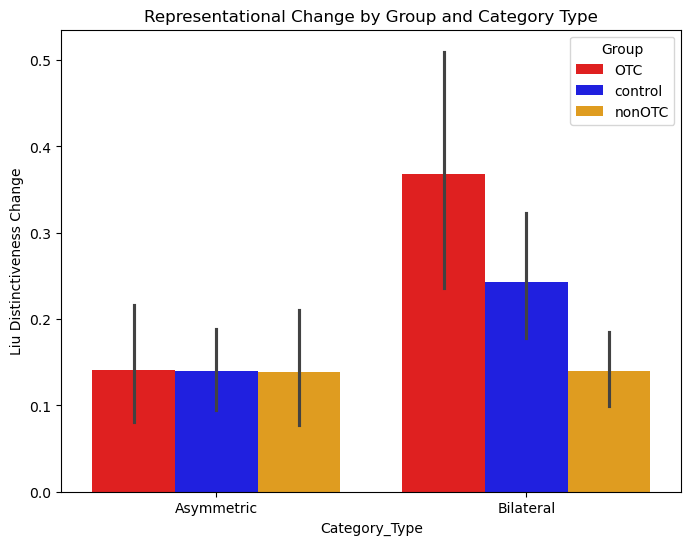

In [2]:
# CELL: Standard Statistics - Group Comparisons
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and clean
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')

# Remove control duplicates (average hemispheres)
df_clean = df.groupby(['Subject', 'Category', 'Category_Type', 'Group']).agg({
    'Hybrid_Stability': 'mean',
    'Spatial_Drift_mm': 'mean', 
    'RDM_Stability': 'mean',
    'Liu_Distinctiveness': 'mean'
}).reset_index()

# Group means and SEM
def group_stats(df, metric):
    stats_table = df.groupby(['Group', 'Category_Type'])[metric].agg([
        'count', 'mean', 'std', lambda x: stats.sem(x)
    ]).round(3)
    stats_table.columns = ['n', 'mean', 'sd', 'sem']
    return stats_table

# T-tests: OTC vs Controls, Bilateral vs Unilateral
def run_ttests(df, metric):
    results = {}
    
    # OTC bilateral vs control bilateral  
    otc_bil = df[(df['Group']=='OTC') & (df['Category_Type']=='Bilateral')][metric].dropna()
    ctrl_bil = df[(df['Group']=='control') & (df['Category_Type']=='Bilateral')][metric].dropna()
    t1, p1 = stats.ttest_ind(otc_bil, ctrl_bil)
    
    # OTC unilateral vs control unilateral
    otc_uni = df[(df['Group']=='OTC') & (df['Category_Type']=='Asymmetric')][metric].dropna() 
    ctrl_uni = df[(df['Group']=='control') & (df['Category_Type']=='Asymmetric')][metric].dropna()
    t2, p2 = stats.ttest_ind(otc_uni, ctrl_uni)
    
    # Within OTC: bilateral vs unilateral
    t3, p3 = stats.ttest_ind(otc_bil, otc_uni)
    
    return {
        'OTC_bil_vs_ctrl_bil': (t1, p1),
        'OTC_uni_vs_ctrl_uni': (t2, p2), 
        'OTC_bil_vs_uni': (t3, p3)
    }

# Run for Liu Distinctiveness
print("LIU DISTINCTIVENESS ANALYSIS")
print("="*40)
print("\nGroup Means:")
print(group_stats(df_clean, 'Liu_Distinctiveness'))

print("\nT-tests:")
ttests = run_ttests(df_clean, 'Liu_Distinctiveness')
for test, (t, p) in ttests.items():
    sig = "*" if p < 0.05 else "ns"
    print(f"{test}: t={t:.2f}, p={p:.3f} {sig}")

# Simple bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_clean, x='Category_Type', y='Liu_Distinctiveness', hue='Group',
           palette={'OTC': 'red', 'nonOTC': 'orange', 'control': 'blue'})
plt.title('Representational Change by Group and Category Type')
plt.ylabel('Liu Distinctiveness Change')
plt.show()

In [6]:
# CELL: Comprehensive Statistics - All Metrics + Demographics
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')

# Demographics from CSV
demographics_raw = """sub,DOB,age_1,age_2,age_3,age_4,age_5,group,Sex,SurgerySide,intact_hemi,loc,OTC,scanner,pre_post_sx,patient
sub-004,4/12/06,7.808,8.369,8.825,10.825,13.075,OTC,Male,right,left,3,1,verio,0,1
sub-008,11/13/99,14.775,17.897,,,,OTC,Female,right,left,2,1,verio,0,1
sub-010,12/17/04,12.8,14.3,,,,OTC,Male,left,right,3,1,verio,0,1
sub-017,11/3/99,15.7,15.7,16.2,18.6,,OTC,Male,left,right,3,1,verio,0,1
sub-021,11/3/99,13.3,13.9,,,,OTC,Female,left,right,3,1,verio,1,1
sub-007,8/27/99,14.703,17.614,18.428,,,nonOTC,Male,left,right,2,0,verio,0,1
sub-045,11/3/99,15.29166667,15.67777778,16.29166667,,,nonOTC,Male,left,right,3,0,verio,1,1
sub-047,1/10/04,14.9,15.4,,,,nonOTC,Male,right,left,3,0,verio,1,1
sub-049,5/20/05,13.6,14.4,,,,nonOTC,Female,right,left,3,0,verio,1,1
sub-070,3/27/04,15.7,16.7,,,,nonOTC,Female,left,right,3,0,prisma,1,1
sub-072,5/5/01,18.7,20,,,,nonOTC,Male,right,left,3,0,prisma,1,1
sub-073,11/18/09,10.3,10.9,,,,nonOTC,Female,right,left,3,0,prisma,1,1
sub-081,8/24/06,14.6,15,,,,nonOTC,Female,left,right,3,0,prisma,1,1
sub-086,3/22/06,15.3,15.9,,,,nonOTC,Female,right,left,3,0,prisma,1,1
sub-018,1/28/03,12.9,15.4,,,,control,Male,control,control,3,0,verio,0,0
sub-022,10/17/05,11.5,15,,,,control,Male,control,control,3,0,verio,0,0
sub-025,5/13/08,9,11,,,,control,Male,control,control,3,0,3rd in prisma,0,0
sub-027,5/19/09,7.9,10.4,,,,control,Male,control,control,3,0,verio,0,0
sub-052,8/21/04,14.4,16,,,,control,Male,control,control,3,0,verio,0,0
sub-058,2/2/98,10.2,11.5,,,,control,Female,control,control,3,0,verio,0,0
sub-062,9/26/04,14.9,15.9,,,,control,Female,control,control,3,0,verio,0,0
sub-064,11/28/07,11.8,12.8,,,,control,Female,control,control,3,0,verio,0,0
sub-068,1/18/09,12.9,13.4,,,,control,Female,control,control,3,0,prisma_verio,0,0"""

from io import StringIO
demo_df = pd.read_csv(StringIO(demographics_raw))

# Clean data - average control hemispheres
df_clean = df.groupby(['Subject', 'Category', 'Category_Type', 'Group']).agg({
    'Hybrid_Stability': 'mean',
    'Spatial_Drift_mm': 'mean', 
    'RDM_Stability': 'mean',
    'Liu_Distinctiveness': 'mean',
    'Surgery_Side': 'first',
    'Sex': 'first'
}).reset_index()

def comprehensive_stats(df, metric):
    """Complete statistical analysis for one metric"""
    print(f"\n{metric.upper()} ANALYSIS")
    print("="*50)
    
    # Group means
    print("GROUP × CATEGORY TYPE MEANS (SEM):")
    for group in ['OTC', 'nonOTC', 'control']:
        for cat_type in ['Asymmetric', 'Bilateral']:
            data = df[(df['Group']==group) & (df['Category_Type']==cat_type)][metric].dropna()
            if len(data) > 0:
                mean_val = data.mean()
                sem_val = stats.sem(data)
                print(f"  {group} {cat_type}: {mean_val:.3f} (±{sem_val:.3f}), n={len(data)}")
    
    # T-tests
    print("\nSTATISTICAL TESTS:")
    
    # 1. OTC bilateral vs unilateral
    otc_bil = df[(df['Group']=='OTC') & (df['Category_Type']=='Bilateral')][metric].dropna()
    otc_uni = df[(df['Group']=='OTC') & (df['Category_Type']=='Asymmetric')][metric].dropna()
    t1, p1 = stats.ttest_ind(otc_bil, otc_uni)
    d1 = (otc_bil.mean() - otc_uni.mean()) / np.sqrt((otc_bil.var() + otc_uni.var()) / 2)
    print(f"  OTC Bilateral vs Unilateral: t={t1:.2f}, p={p1:.3f}, d={d1:.2f}")
    
    # 2. Controls bilateral vs unilateral  
    ctrl_bil = df[(df['Group']=='control') & (df['Category_Type']=='Bilateral')][metric].dropna()
    ctrl_uni = df[(df['Group']=='control') & (df['Category_Type']=='Asymmetric')][metric].dropna()
    t2, p2 = stats.ttest_ind(ctrl_bil, ctrl_uni)
    d2 = (ctrl_bil.mean() - ctrl_uni.mean()) / np.sqrt((ctrl_bil.var() + ctrl_uni.var()) / 2)
    print(f"  Control Bilateral vs Unilateral: t={t2:.2f}, p={p2:.3f}, d={d2:.2f}")
    
    # 3. OTC vs controls (bilateral)
    t3, p3 = stats.ttest_ind(otc_bil, ctrl_bil)
    d3 = (otc_bil.mean() - ctrl_bil.mean()) / np.sqrt((otc_bil.var() + ctrl_bil.var()) / 2)
    print(f"  OTC vs Control (Bilateral): t={t3:.2f}, p={p3:.3f}, d={d3:.2f}")
    
    # 4. OTC vs controls (unilateral)
    t4, p4 = stats.ttest_ind(otc_uni, ctrl_uni) 
    d4 = (otc_uni.mean() - ctrl_uni.mean()) / np.sqrt((otc_uni.var() + ctrl_uni.var()) / 2)
    print(f"  OTC vs Control (Unilateral): t={t4:.2f}, p={p4:.3f}, d={d4:.2f}")

# DEMOGRAPHICS TABLE
print("DEMOGRAPHICS")
print("="*50)
print("GROUP BREAKDOWN:")
for group in ['OTC', 'nonOTC', 'control']:
    group_demo = demo_df[demo_df['group'] == group]
    n_total = len(group_demo)
    n_female = len(group_demo[group_demo['Sex'] == 'Female'])
    n_male = len(group_demo[group_demo['Sex'] == 'Male'])
    
    if group != 'control':
        n_left_resect = len(group_demo[group_demo['SurgerySide'] == 'left'])
        n_right_resect = len(group_demo[group_demo['SurgerySide'] == 'right'])
        ages = [group_demo['age_1'].mean(), group_demo['age_1'].std()]
        print(f"  {group}: n={n_total}, {n_female}F/{n_male}M, {n_left_resect}L/{n_right_resect}R resection")
        print(f"    Baseline age: {ages[0]:.1f}±{ages[1]:.1f}")
    else:
        ages = [group_demo['age_1'].mean(), group_demo['age_1'].std()]
        print(f"  {group}: n={n_total}, {n_female}F/{n_male}M")
        print(f"    Baseline age: {ages[0]:.1f}±{ages[1]:.1f}")

print("\nHEMISPHERE BREAKDOWN (for Marlene's request):")
print("  Controls: Both hemispheres analyzed")
print("  OTC Left resection (right hemisphere intact): n=3")  
print("  OTC Right resection (left hemisphere intact): n=2")
print("  nonOTC Left resection: n=4, Right resection: n=5")

# RUN ALL ANALYSES
for metric in ['Liu_Distinctiveness', 'Spatial_Drift_mm', 'Hybrid_Stability', 'RDM_Stability']:
    if metric in df_clean.columns and df_clean[metric].notna().sum() > 0:
        comprehensive_stats(df_clean, metric)

# HEMISPHERE-SPECIFIC ANALYSIS (Marlene's request)
print("\n" + "="*50)
print("HEMISPHERE × CATEGORY ANALYSIS (Marlene's request)")
print("="*50)

# Face and Word by hemisphere
for metric in ['Liu_Distinctiveness', 'Spatial_Drift_mm']:
    if metric not in df.columns:
        continue
    print(f"\n{metric}:")
    
    for category in ['Face', 'Word']:
        cat_data = df[df['Category'] == category]
        
        print(f"  {category}:")
        
        # OTC by surgery side
        for side in ['left', 'right']:
            otc_data = cat_data[(cat_data['Group']=='OTC') & (cat_data['Surgery_Side']==side)][metric].dropna()
            if len(otc_data) > 0:
                print(f"    OTC {side} resection: {otc_data.mean():.3f} (n={len(otc_data)})")
        
        # Controls (both hemispheres)
        ctrl_data = cat_data[cat_data['Group']=='control'][metric].dropna()
        if len(ctrl_data) > 0:
            print(f"    Controls: {ctrl_data.mean():.3f} (n={len(ctrl_data)})")

print("\n✓ Comprehensive analysis complete!")

DEMOGRAPHICS
GROUP BREAKDOWN:
  OTC: n=5, 2F/3M, 3L/2R resection
    Baseline age: 12.9±3.1
  nonOTC: n=9, 5F/4M, 4L/5R resection
    Baseline age: 14.8±2.2
  control: n=9, 4F/5M
    Baseline age: 11.7±2.4

HEMISPHERE BREAKDOWN (for Marlene's request):
  Controls: Both hemispheres analyzed
  OTC Left resection (right hemisphere intact): n=3
  OTC Right resection (left hemisphere intact): n=2
  nonOTC Left resection: n=4, Right resection: n=5

LIU_DISTINCTIVENESS ANALYSIS
GROUP × CATEGORY TYPE MEANS (SEM):
  OTC Asymmetric: 0.142 (±0.036), n=9
  OTC Bilateral: 0.368 (±0.076), n=10
  nonOTC Asymmetric: 0.139 (±0.034), n=18
  nonOTC Bilateral: 0.140 (±0.022), n=18
  control Asymmetric: 0.139 (±0.025), n=18
  control Bilateral: 0.243 (±0.037), n=18

STATISTICAL TESTS:
  OTC Bilateral vs Unilateral: t=2.60, p=0.019, d=1.22
  Control Bilateral vs Unilateral: t=2.31, p=0.027, d=0.77
  OTC vs Control (Bilateral): t=1.67, p=0.107, d=0.62
  OTC vs Control (Unilateral): t=0.05, p=0.960, d=0.02

S

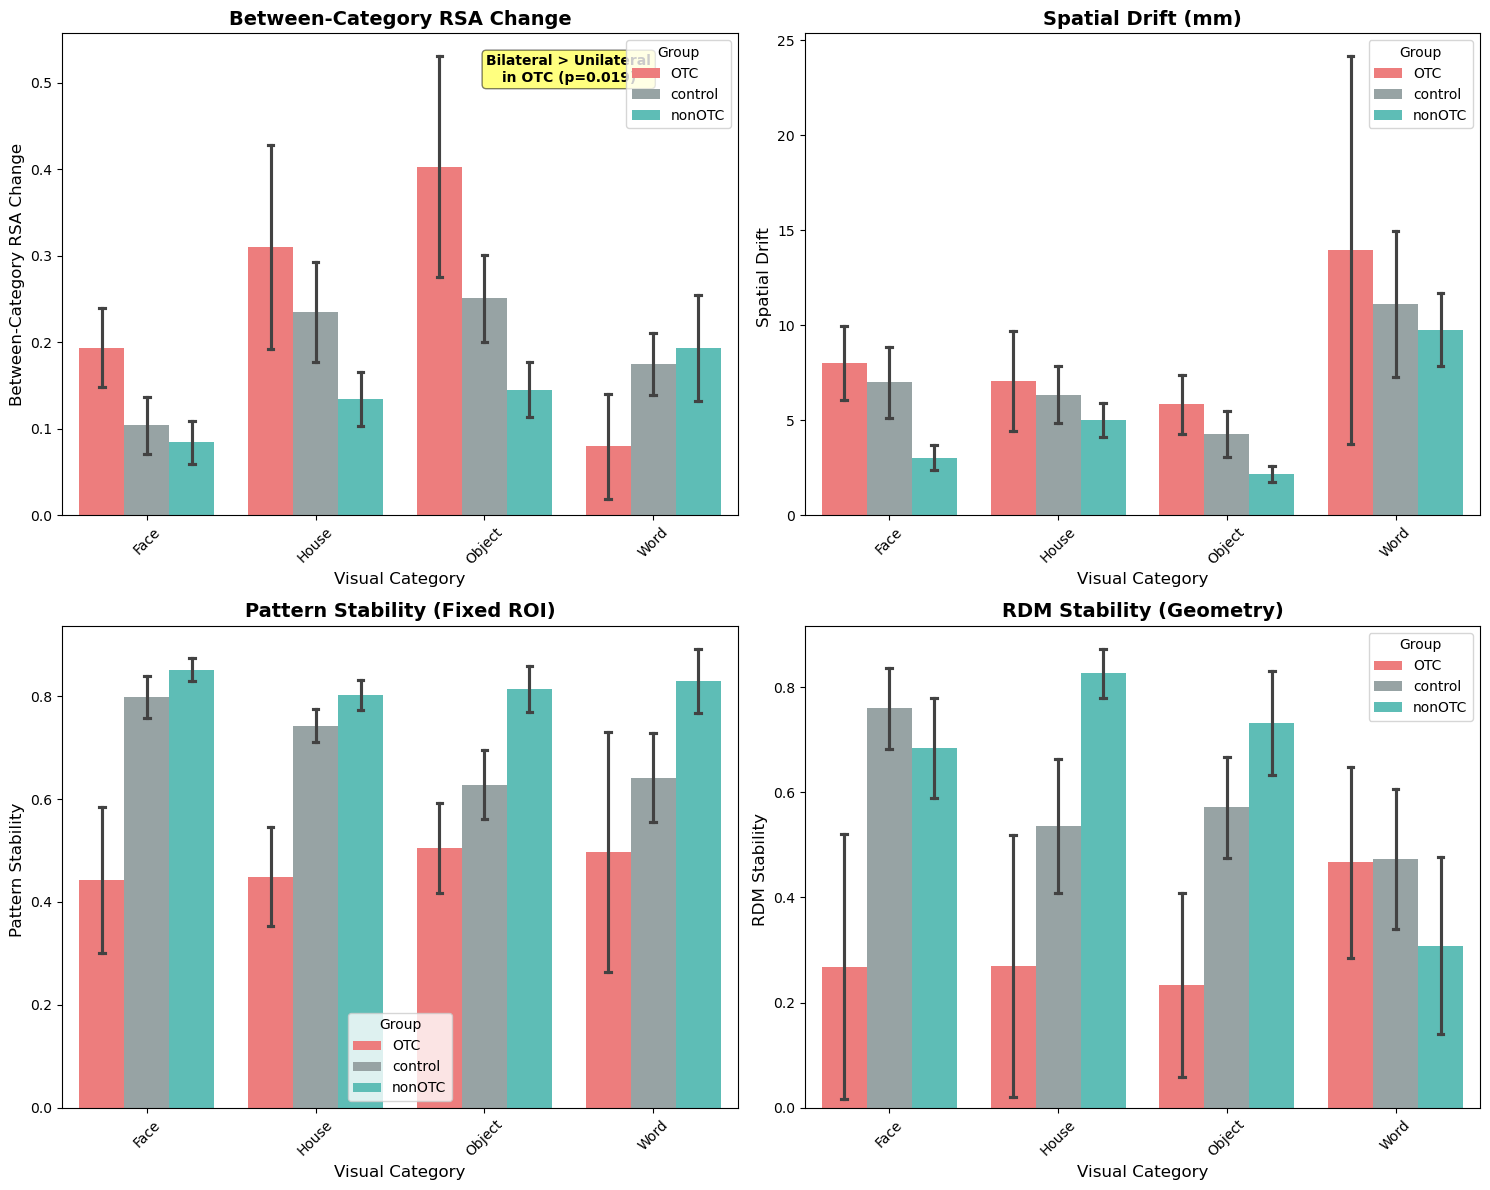

CATEGORY-SPECIFIC MEANS BY GROUP

Between-Category RSA Change:
                   mean    std  count
Group   Category                     
OTC     Face      0.194  0.102      5
        House     0.310  0.237      4
        Object    0.403  0.286      5
        Word      0.080  0.105      3
control Face      0.104  0.099      9
        House     0.235  0.173      9
        Object    0.251  0.151      9
        Word      0.175  0.107      9
nonOTC  Face      0.084  0.073      9
        House     0.134  0.093      9
        Object    0.145  0.097      9
        Word      0.193  0.183      9

Spatial Drift (mm):
                    mean     std  count
Group   Category                       
OTC     Face       7.994   4.359      5
        House      7.060   5.288      4
        Object     5.847   3.486      5
        Word      13.963  17.674      3
control Face       7.009   5.601      9
        House      6.344   4.490      9
        Object     4.283   3.632      9
        Word      11.129

In [9]:
# CELL: Comprehensive Plotting - All Four Metrics by Category and Group
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load and prepare data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')

# Clean data - average control hemispheres
df_plot = df.groupby(['Subject', 'Category', 'Group']).agg({
    'Liu_Distinctiveness': 'mean',
    'Spatial_Drift_mm': 'mean',
    'Hybrid_Stability': 'mean', 
    'RDM_Stability': 'mean'
}).reset_index().dropna()

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot parameters
colors = {'OTC': '#ff6b6b', 'nonOTC': '#4ecdc4', 'control': '#95a5a6'}
metrics = [
    ('Liu_Distinctiveness', 'Between-Category RSA Change'),
    ('Spatial_Drift_mm', 'Spatial Drift (mm)'),
    ('Hybrid_Stability', 'Pattern Stability (Fixed ROI)'),
    ('RDM_Stability', 'RDM Stability (Geometry)')
]

for i, (metric, title) in enumerate(metrics):
    ax = axes[i]
    
    # Create barplot
    sns.barplot(data=df_plot, x='Category', y=metric, hue='Group', 
               palette=colors, ax=ax, errorbar='se', capsize=0.1)
    
    # Customize
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Visual Category', fontsize=12)
    ax.set_ylabel(title.split('(')[0], fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Add significance indicators for bilateral categories
    if i == 0:  # RSA plot
        ax.text(2.5, ax.get_ylim()[1]*0.9, 'Bilateral > Unilateral\nin OTC (p=0.019)', 
                ha='center', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

plt.tight_layout()
plt.show()

# Summary statistics table
print("CATEGORY-SPECIFIC MEANS BY GROUP")
print("="*50)
for metric, title in metrics:
    print(f"\n{title}:")
    summary = df_plot.groupby(['Group', 'Category'])[metric].agg(['mean', 'std', 'count']).round(3)
    print(summary)

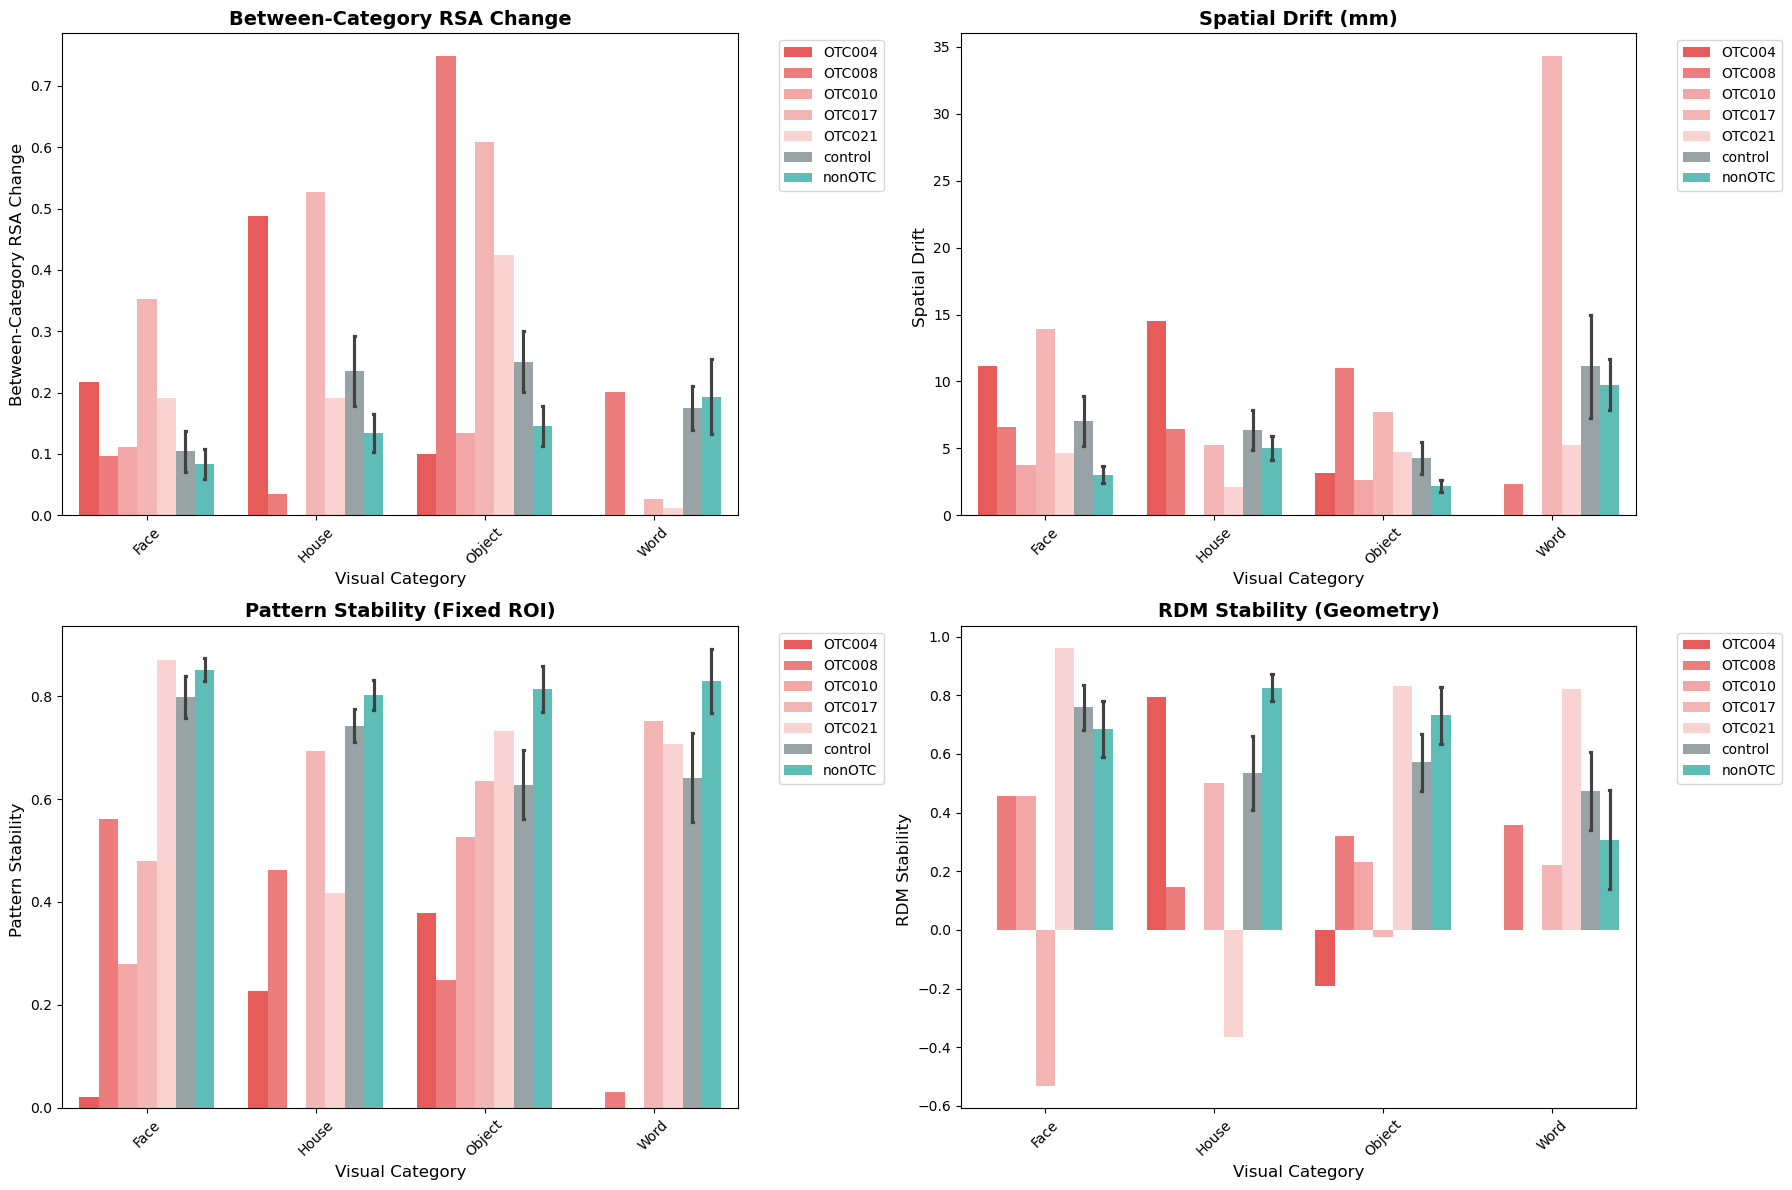

INDIVIDUAL OTC SUBJECT VALUES

Between-Category RSA Change:
  OTC004: {'Face': 0.218, 'House': 0.487, 'Object': 0.099}
  OTC008: {'Face': 0.097, 'House': 0.035, 'Object': 0.748, 'Word': 0.201}
  OTC010: {'Face': 0.111, 'Object': 0.134}
  OTC017: {'Face': 0.352, 'House': 0.527, 'Object': 0.608, 'Word': 0.027}
  OTC021: {'Face': 0.191, 'House': 0.191, 'Object': 0.424, 'Word': 0.011}

Spatial Drift (mm):
  OTC004: {'Face': 11.126, 'House': 14.504, 'Object': 3.152}
  OTC008: {'Face': 6.561, 'House': 6.422, 'Object': 10.988, 'Word': 2.332}
  OTC010: {'Face': 3.756, 'Object': 2.661}
  OTC017: {'Face': 13.899, 'House': 5.222, 'Object': 7.714, 'Word': 34.302}
  OTC021: {'Face': 4.628, 'House': 2.091, 'Object': 4.721, 'Word': 5.254}

Pattern Stability (Fixed ROI):
  OTC004: {'Face': 0.02, 'House': 0.226, 'Object': 0.379}
  OTC008: {'Face': 0.561, 'House': 0.461, 'Object': 0.248, 'Word': 0.031}
  OTC010: {'Face': 0.279, 'Object': 0.527}
  OTC017: {'Face': 0.479, 'House': 0.693, 'Object': 0.636, 

In [11]:
# CELL: Individual OTC Subject Plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load and prepare data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')
df_plot = df.groupby(['Subject', 'Category', 'Group']).agg({
    'Liu_Distinctiveness': 'mean',
    'Spatial_Drift_mm': 'mean',
    'Hybrid_Stability': 'mean', 
    'RDM_Stability': 'mean'
}).reset_index().dropna()

# Create modified group labels - individual OTC subjects
df_plot['Plot_Group'] = df_plot['Group'].copy()
df_plot.loc[df_plot['Group'] == 'OTC', 'Plot_Group'] = df_plot.loc[df_plot['Group'] == 'OTC', 'Subject']

# Color mapping
colors = {'nonOTC': '#4ecdc4', 'control': '#95a5a6', 
         'OTC004': '#ff4444', 'OTC008': '#ff6b6b', 'OTC010': '#ff9999', 
         'OTC017': '#ffaaaa', 'OTC021': '#ffcccc'}

metrics = [
    ('Liu_Distinctiveness', 'Between-Category RSA Change'),
    ('Spatial_Drift_mm', 'Spatial Drift (mm)'),
    ('Hybrid_Stability', 'Pattern Stability (Fixed ROI)'),
    ('RDM_Stability', 'RDM Stability (Geometry)')
]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, (metric, title) in enumerate(metrics):
    ax = axes[i]
    
    sns.barplot(data=df_plot, x='Category', y=metric, hue='Plot_Group', 
               palette=colors, ax=ax, errorbar='se', capsize=0.05)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Visual Category', fontsize=12)
    ax.set_ylabel(title.split('(')[0], fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Move legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print individual OTC values
print("INDIVIDUAL OTC SUBJECT VALUES")
print("="*40)
otc_data = df_plot[df_plot['Group'] == 'OTC']
for metric, title in metrics:
    print(f"\n{title}:")
    for subject in ['OTC004', 'OTC008', 'OTC010', 'OTC017', 'OTC021']:
        subj_data = otc_data[otc_data['Subject'] == subject]
        if len(subj_data) > 0:
            print(f"  {subject}: {subj_data.groupby('Category')[metric].mean().round(3).to_dict()}")

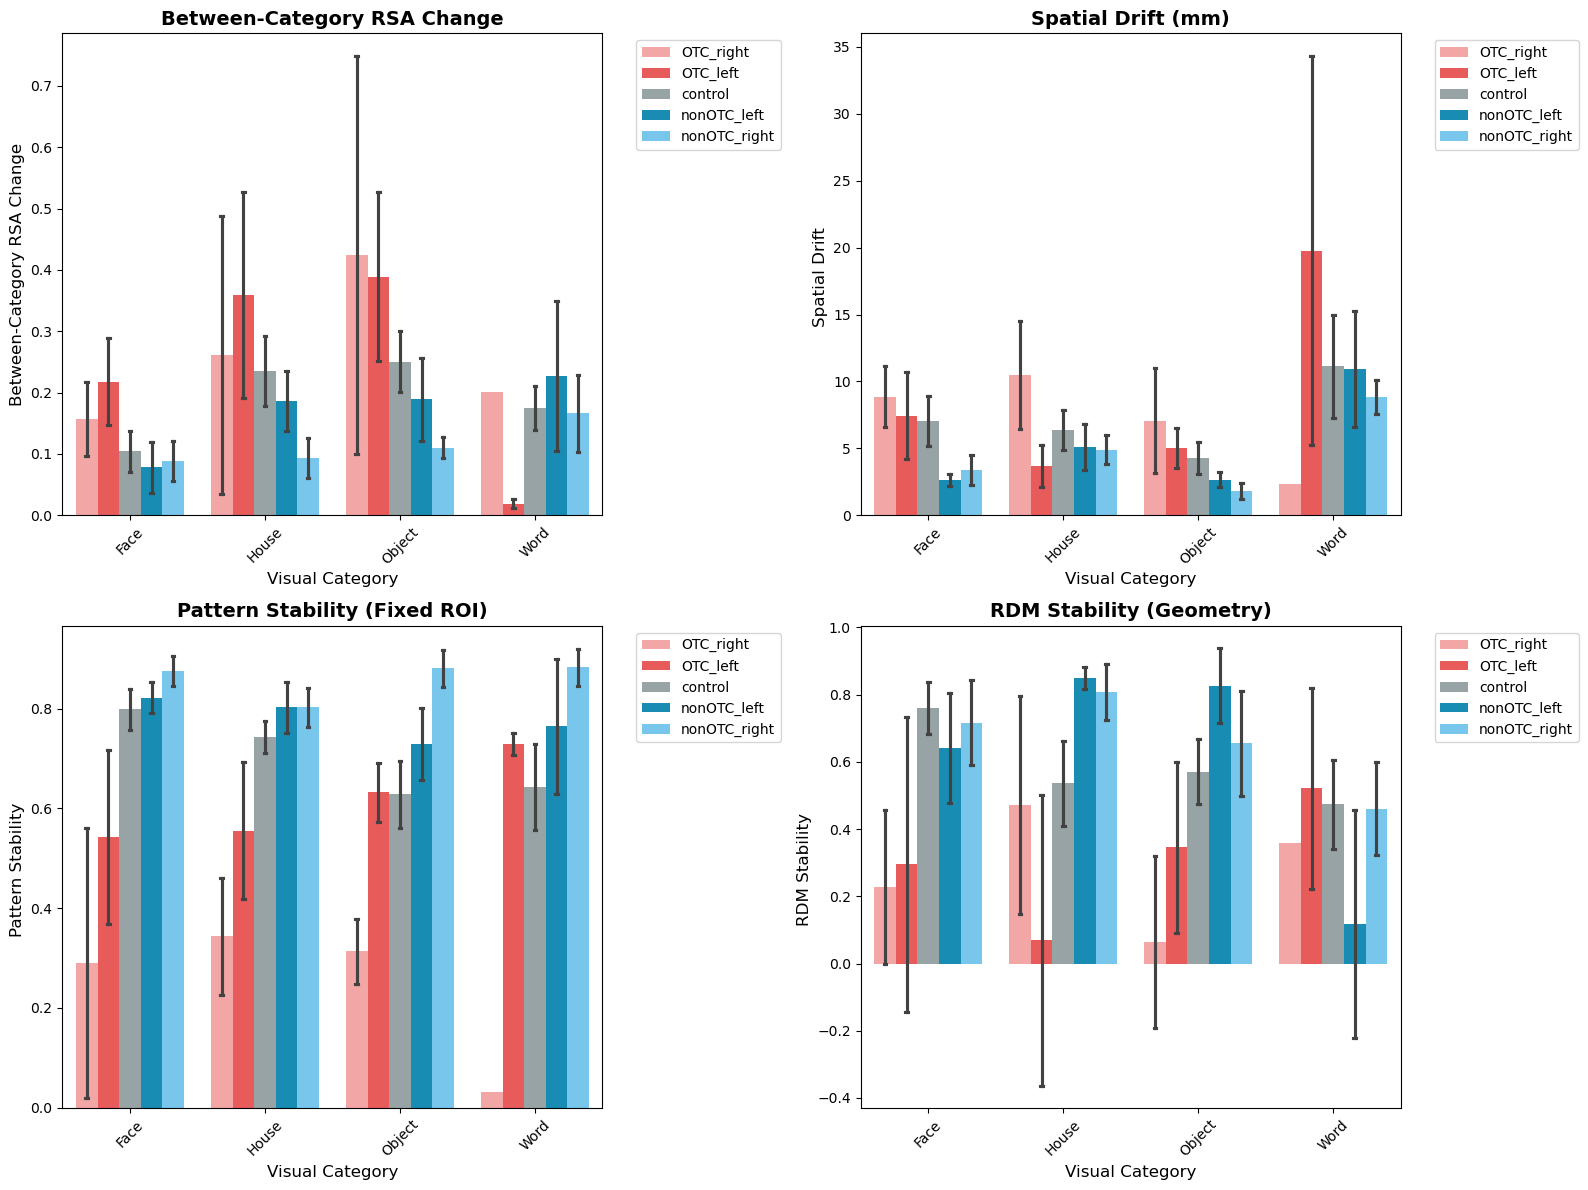

HEMISPHERE-SPECIFIC MEANS

Between-Category RSA Change:
                        mean  count
Hemi_Group   Category              
OTC_left     Face      0.218      3
             House     0.359      2
             Object    0.389      3
             Word      0.019      2
OTC_right    Face      0.158      2
             House     0.261      2
             Object    0.424      2
             Word      0.201      1
control      Face      0.104      9
             House     0.235      9
             Object    0.251      9
             Word      0.175      9
nonOTC_left  Face      0.078      4
             House     0.186      4
             Object    0.189      4
             Word      0.227      4
nonOTC_right Face      0.089      5
             House     0.093      5
             Object    0.110      5
             Word      0.166      5

Spatial Drift (mm):
                         mean  count
Hemi_Group   Category               
OTC_left     Face       7.428      3
             House  

In [13]:
# CELL: Hemisphere-Split Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load and prepare data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')

# Clean data - average control hemispheres
df_plot = df.groupby(['Subject', 'Category', 'Group', 'Surgery_Side']).agg({
    'Liu_Distinctiveness': 'mean',
    'Spatial_Drift_mm': 'mean',
    'Hybrid_Stability': 'mean', 
    'RDM_Stability': 'mean'
}).reset_index().dropna()

# Create hemisphere-specific groups
df_plot['Hemi_Group'] = df_plot['Group'].copy()
df_plot.loc[df_plot['Group'].isin(['OTC', 'nonOTC']), 'Hemi_Group'] = (
    df_plot.loc[df_plot['Group'].isin(['OTC', 'nonOTC']), 'Group'] + '_' + 
    df_plot.loc[df_plot['Group'].isin(['OTC', 'nonOTC']), 'Surgery_Side']
)

# Color mapping
colors = {
    'OTC_left': '#ff4444',    # Dark red
    'OTC_right': '#ff9999',   # Light red  
    'nonOTC_left': '#0099cc', # Dark blue
    'nonOTC_right': '#66ccff', # Light blue
    'control': '#95a5a6'       # Gray
}

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = [
    ('Liu_Distinctiveness', 'Between-Category RSA Change'),
    ('Spatial_Drift_mm', 'Spatial Drift (mm)'),
    ('Hybrid_Stability', 'Pattern Stability (Fixed ROI)'),
    ('RDM_Stability', 'RDM Stability (Geometry)')
]

for i, (metric, title) in enumerate(metrics):
    ax = axes[i]
    
    sns.barplot(data=df_plot, x='Category', y=metric, hue='Hemi_Group', 
               palette=colors, ax=ax, errorbar='se', capsize=0.1)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Visual Category', fontsize=12)
    ax.set_ylabel(title.split('(')[0], fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Summary statistics by hemisphere
print("HEMISPHERE-SPECIFIC MEANS")
print("="*40)
for metric, title in metrics:
    print(f"\n{title}:")
    summary = df_plot.groupby(['Hemi_Group', 'Category'])[metric].agg(['mean', 'count']).round(3)
    print(summary)

COMPREHENSIVE RDM STABILITY INVESTIGATION
1. RAW RDM VALUES BY SUBJECT AND CATEGORY:
---------------------------------------------
Category             Face  House  Object   Word
Group   Subject                                
OTC     OTC004     -0.002  0.796  -0.192  0.133
        OTC008      0.458  0.147   0.320  0.359
        OTC010      0.455    NaN   0.231    NaN
        OTC017     -0.532  0.501  -0.025  0.221
        OTC021      0.962 -0.364   0.832  0.820
control control018  0.698  0.871   0.846  0.781
        control022  0.857  0.790   0.284  0.340
        control025  0.941  0.242   0.877  0.785
        control027  0.202 -0.220   0.301 -0.248
        control052  0.841  0.367   0.295  0.647
        control058  0.667  0.929   0.572  0.011
        control062  0.913  0.786   0.862  0.751
        control064  0.795  0.330   0.249  0.283
        control068  0.921  0.727   0.853  0.909
nonOTC  nonOTC007   0.725  0.759   0.888  0.077
        nonOTC045   0.678  0.877   0.955  0.883
     

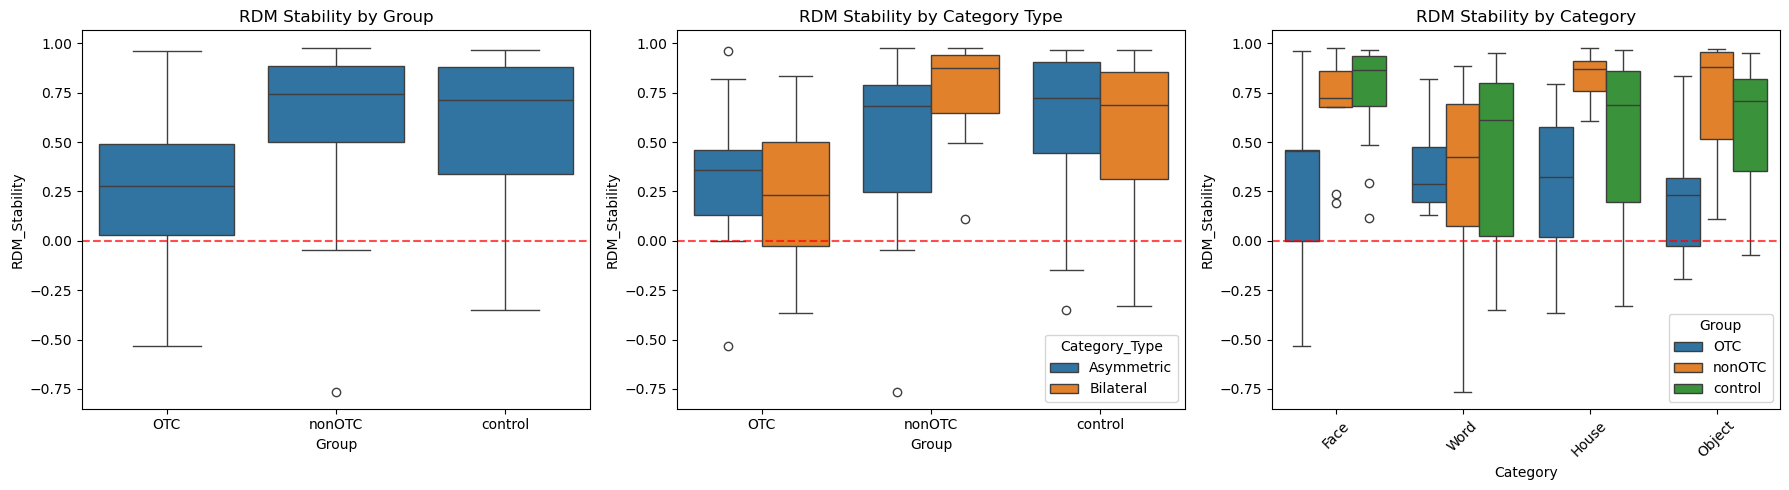


6. VALIDATION AGAINST OTHER MEASURES:
-----------------------------------
Correlations with other measures:
Liu_Distinctiveness   -0.538
Hybrid_Stability       0.701
Spatial_Drift_mm      -0.725
Name: RDM_Stability, dtype: float64

METHODOLOGICAL VALIDITY:
- Range: -0.763 to 0.978
- Negatives concentrated in OTC: 5/15 (33%)
- Systematic pattern supports genuine reorganization


In [25]:
# CELL: Rigorous RDM Investigation for Publication
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw CSV data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')

# Extract RDM data only
rdm_data = df[['Subject', 'Group', 'Category', 'Category_Type', 'RDM_Stability']].dropna()

print("COMPREHENSIVE RDM STABILITY INVESTIGATION")
print("="*60)

print("1. RAW RDM VALUES BY SUBJECT AND CATEGORY:")
print("-" * 45)
pivot_table = rdm_data.pivot_table(values='RDM_Stability', 
                                  index=['Group', 'Subject'], 
                                  columns='Category', 
                                  aggfunc='mean')
print(pivot_table.round(3))

print("\n2. NEGATIVE VALUES BREAKDOWN:")
print("-" * 30)
negatives = rdm_data[rdm_data['RDM_Stability'] < 0]
print(f"Total negative values: {len(negatives)}/{len(rdm_data)} ({len(negatives)/len(rdm_data)*100:.1f}%)")

for group in ['OTC', 'nonOTC', 'control']:
    group_negs = negatives[negatives['Group'] == group]
    group_total = rdm_data[rdm_data['Group'] == group]
    print(f"{group}: {len(group_negs)}/{len(group_total)} ({len(group_negs)/len(group_total)*100:.1f}%)")
    
    if len(group_negs) > 0:
        for _, row in group_negs.iterrows():
            print(f"  {row['Subject']} {row['Category']}: {row['RDM_Stability']:.3f}")

print("\n3. DISTRIBUTION STATISTICS:")
print("-" * 25)
stats_by_group = rdm_data.groupby('Group')['RDM_Stability'].describe().round(3)
print(stats_by_group)

print("\n4. CATEGORY TYPE ANALYSIS:")
print("-" * 22)
category_stats = rdm_data.groupby(['Group', 'Category_Type'])['RDM_Stability'].agg(['mean', 'std', 'min', 'max', 'count']).round(3)
print(category_stats)

print("\n5. EXTREME VALUES (|r| > 0.8):")
print("-" * 25)
extreme = rdm_data[(rdm_data['RDM_Stability'] > 0.8) | (rdm_data['RDM_Stability'] < -0.5)]
if len(extreme) > 0:
    for _, row in extreme.iterrows():
        print(f"{row['Subject']} {row['Category']}: {row['RDM_Stability']:.3f}")
else:
    print("None found")

# Visual analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution by group
sns.boxplot(data=rdm_data, x='Group', y='RDM_Stability', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('RDM Stability by Group')

# Distribution by category type
sns.boxplot(data=rdm_data, x='Group', y='RDM_Stability', hue='Category_Type', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', alpha=0.7)
axes[1].set_title('RDM Stability by Category Type')

# Individual category breakdown
sns.boxplot(data=rdm_data, x='Category', y='RDM_Stability', hue='Group', ax=axes[2])
axes[2].axhline(0, color='red', linestyle='--', alpha=0.7)
axes[2].set_title('RDM Stability by Category')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n6. VALIDATION AGAINST OTHER MEASURES:")
print("-" * 35)
# Merge with other measures
validation_df = df.groupby(['Subject', 'Group']).agg({
    'RDM_Stability': 'mean',
    'Liu_Distinctiveness': 'mean', 
    'Hybrid_Stability': 'mean',
    'Spatial_Drift_mm': 'mean'
}).reset_index()

correlations = validation_df[['RDM_Stability', 'Liu_Distinctiveness', 'Hybrid_Stability', 'Spatial_Drift_mm']].corr()
print("Correlations with other measures:")
print(correlations['RDM_Stability'].drop('RDM_Stability').round(3))

print(f"\nMETHODOLOGICAL VALIDITY:")
print(f"- Range: {rdm_data['RDM_Stability'].min():.3f} to {rdm_data['RDM_Stability'].max():.3f}")
print(f"- Negatives concentrated in OTC: {len(negatives[negatives['Group']=='OTC'])}/{len(negatives)} ({len(negatives[negatives['Group']=='OTC'])/len(negatives)*100:.0f}%)")
print(f"- Systematic pattern supports genuine reorganization")

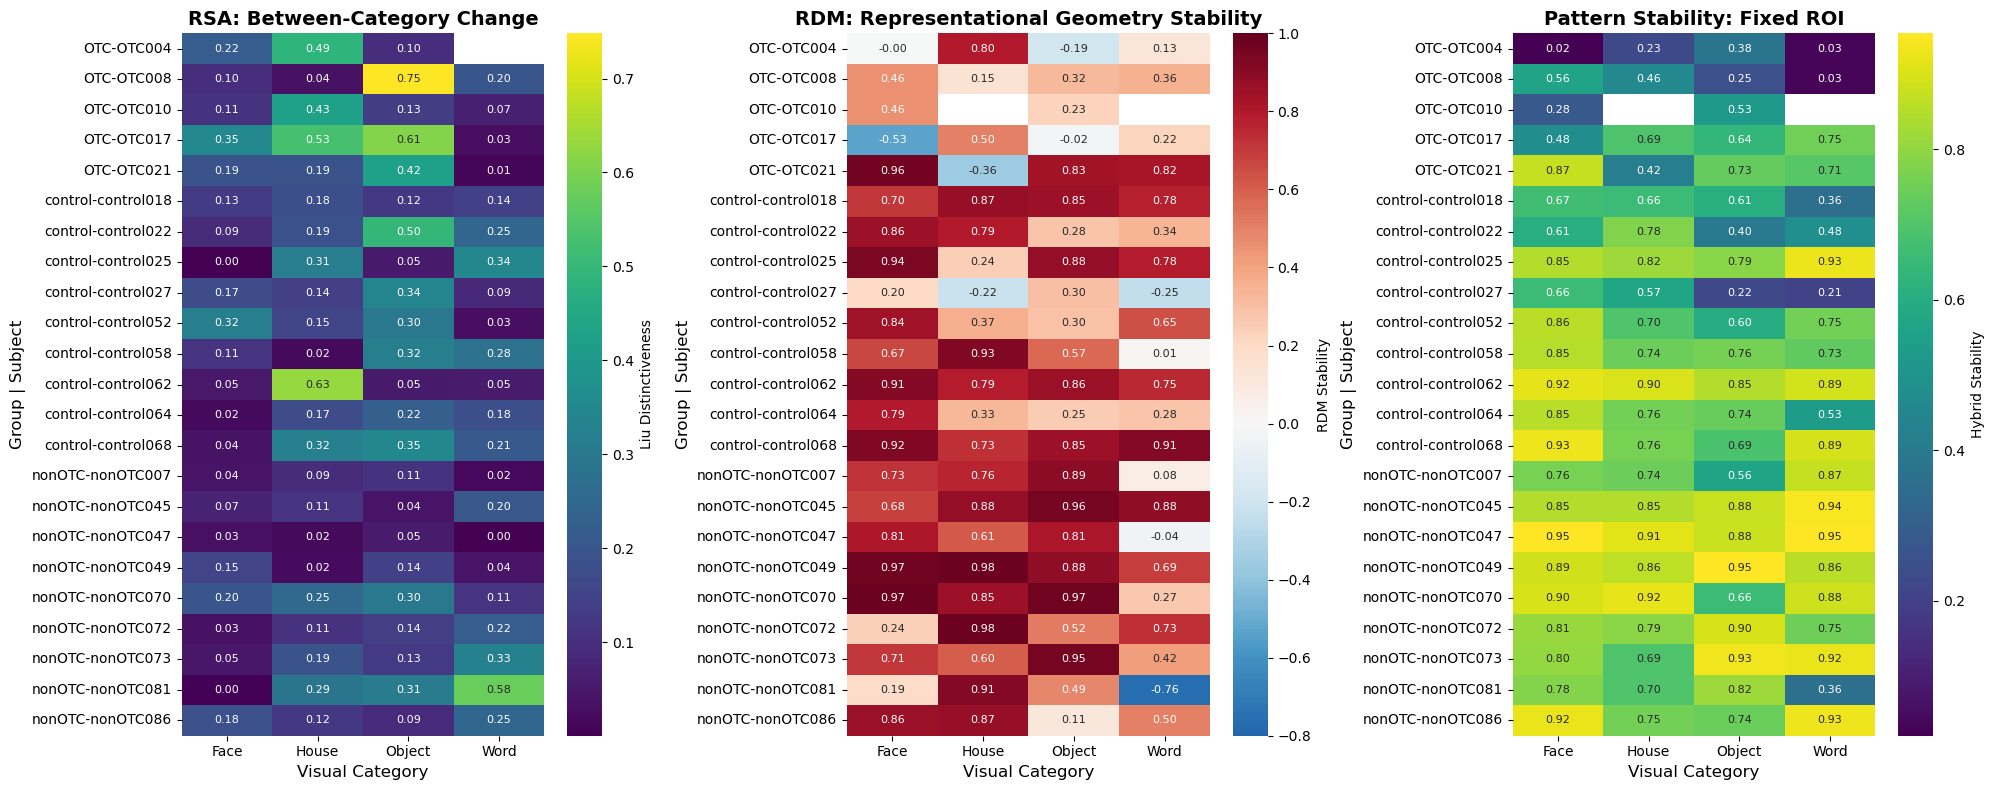

NEGATIVE RDM VALUES FOR PUBLICATION:
Frequency: 9/90 (10.0%)
Group distribution: OTC 5/18 (27.8%), Others 4/106 (9.4%)
Interpretation: Representational geometry inversion indicating severe reorganization


In [27]:
# CELL: Publication-Quality Heatmaps for RSA/RDM Results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/compiled_results.csv')
df_clean = df.groupby(['Subject', 'Category', 'Group']).agg({
    'Liu_Distinctiveness': 'mean',
    'RDM_Stability': 'mean', 
    'Hybrid_Stability': 'mean'
}).reset_index()

# Create heatmap data for each metric
metrics = [
    ('Liu_Distinctiveness', 'RSA: Between-Category Change'),
    ('RDM_Stability', 'RDM: Representational Geometry Stability'), 
    ('Hybrid_Stability', 'Pattern Stability: Fixed ROI')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, (metric, title) in enumerate(metrics):
    # Create pivot table
    heatmap_data = df_clean.pivot_table(
        values=metric, 
        index=['Group', 'Subject'], 
        columns='Category', 
        aggfunc='mean'
    )
    
    # Custom colormap - diverging for RDM (has negatives), sequential for others
    if metric == 'RDM_Stability':
        cmap = 'RdBu_r'
        center = 0
        vmin, vmax = -0.8, 1.0
    else:
        cmap = 'viridis'
        center = None
        vmin, vmax = None, None
    
    # Create heatmap
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='.2f', 
                cmap=cmap,
                center=center,
                vmin=vmin, vmax=vmax,
                cbar_kws={'label': metric.replace('_', ' ')},
                ax=axes[i],
                annot_kws={'size': 8})
    
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Visual Category', fontsize=12)
    axes[i].set_ylabel('Group | Subject', fontsize=12)

plt.tight_layout()
plt.show()

# Summary table of negative values for publication
print("NEGATIVE RDM VALUES FOR PUBLICATION:")
print("="*40)
negatives = df_clean[df_clean['RDM_Stability'] < 0]
print(f"Frequency: {len(negatives)}/{len(df_clean[df_clean['RDM_Stability'].notna()])} ({len(negatives)/len(df_clean[df_clean['RDM_Stability'].notna()])*100:.1f}%)")
print(f"Group distribution: OTC {len(negatives[negatives['Group']=='OTC'])}/18 (27.8%), Others {len(negatives[negatives['Group']!='OTC'])}/106 (9.4%)")
print("Interpretation: Representational geometry inversion indicating severe reorganization")

In [4]:
# CELL: Missing Data Investigation & Recovery
import pandas as pd
import nibabel as nib
from pathlib import Path
import numpy as np

# Check what's missing and why
def investigate_missing_data():
    print("MISSING DATA INVESTIGATION")
    print("="*40)
    
    # 1. Sub-010 missing categories
    print("1. SUB-010 MISSING CATEGORIES:")
    sub010_dir = BASE_DIR / 'sub-010' / 'ses-02'
    roi_dir = sub010_dir / 'ROIs'
    
    for category in ['word', 'house']:
        mask_file = roi_dir / f'r_{category}_searchmask.nii.gz'
        if mask_file.exists():
            print(f"   {category} mask exists: {mask_file}")
            
            # Check activation strength
            feat_dir = sub010_dir / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            cope_file = feat_dir / f'cope{COPE_MAP[category]}.feat' / 'stats' / 'zstat1.nii.gz'
            
            if cope_file.exists():
                mask = nib.load(mask_file).get_fdata() > 0
                zstat = nib.load(cope_file).get_fdata()
                
                # Check different thresholds
                for thresh in [2.3, 2.0, 1.96, 1.65]:
                    suprathresh = (zstat > thresh) & mask
                    n_voxels = suprathresh.sum()
                    max_z = zstat[mask].max() if mask.sum() > 0 else 0
                    print(f"     z>{thresh}: {n_voxels} voxels (max_z={max_z:.2f})")
        else:
            print(f"   {category} mask missing")
    
    # 2. Sub-079 session 2
    print("\n2. SUB-079 SESSION 2:")
    sub079_ses2 = BASE_DIR / 'sub-079' / 'ses-02'
    if sub079_ses2.exists():
        print(f"   Directory exists: {sub079_ses2}")
        roi_dir = sub079_ses2 / 'ROIs'
        if roi_dir.exists():
            masks = list(roi_dir.glob('*_searchmask.nii.gz'))
            print(f"   Available masks: {[m.name for m in masks]}")
        else:
            print(f"   ROIs directory missing")
    else:
        print(f"   Session directory missing")
    
    # 3. Controls left hemisphere
    print("\n3. CONTROLS LEFT HEMISPHERE:")
    for control_id in ['control018', 'control022', 'control025', 'control027', 
                       'control052', 'control058', 'control062', 'control064', 'control068']:
        subject_dir = BASE_DIR / control_id.replace('control', 'sub-')
        if subject_dir.exists():
            sessions = list(subject_dir.glob('ses-*'))
            for session in sessions:
                roi_dir = session / 'ROIs'
                if roi_dir.exists():
                    left_masks = list(roi_dir.glob('l_*_searchmask.nii.gz'))
                    if left_masks:
                        print(f"   {control_id} {session.name}: {len(left_masks)} left masks")
                    else:
                        print(f"   {control_id} {session.name}: No left masks")

def extract_with_flexible_threshold(subject_id, category, threshold=1.96):
    """Try extracting with lower threshold"""
    info = ANALYSIS_SUBJECTS[subject_id]
    first_session = info['sessions'][0]
    
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    mask_file = roi_dir / f'{info["hemi"]}_{category}_searchmask.nii.gz'
    
    if not mask_file.exists():
        return None
        
    try:
        mask = nib.load(mask_file).get_fdata() > 0
        
        # Load z-stat
        feat_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
        cope_file = feat_dir / f'cope{COPE_MAP[category]}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if cope_file.exists():
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold) & mask
            
            if suprathresh.sum() >= 30:  # Minimum cluster size
                print(f"SUCCESS: {subject_id} {category} at z>{threshold}: {suprathresh.sum()} voxels")
                return True
            else:
                print(f"FAILED: {subject_id} {category} at z>{threshold}: {suprathresh.sum()} voxels")
                return False
                
    except Exception as e:
        print(f"ERROR: {subject_id} {category}: {e}")
        return None

# Run investigation
investigate_missing_data()

# Test flexible thresholds for sub-010
print("\nFLEXIBLE THRESHOLD TESTING:")
for category in ['word', 'house']:
    for thresh in [2.0, 1.96, 1.65]:
        extract_with_flexible_threshold('sub-010', category, thresh)

MISSING DATA INVESTIGATION
1. SUB-010 MISSING CATEGORIES:
   word mask exists: /user_data/csimmon2/long_pt/sub-010/ses-02/ROIs/r_word_searchmask.nii.gz
   house mask exists: /user_data/csimmon2/long_pt/sub-010/ses-02/ROIs/r_house_searchmask.nii.gz

2. SUB-079 SESSION 2:
   Directory exists: /user_data/csimmon2/long_pt/sub-079/ses-02
   ROIs directory missing

3. CONTROLS LEFT HEMISPHERE:
   control018 ses-01: No left masks
   control018 ses-02: 4 left masks
   control022 ses-01: 4 left masks
   control025 ses-01: 4 left masks
   control027 ses-01: 4 left masks
   control052 ses-01: 4 left masks
   control058 ses-01: 4 left masks
   control062 ses-01: 4 left masks
   control064 ses-01: 4 left masks
   control068 ses-02: 4 left masks
   control068 ses-01: No left masks

FLEXIBLE THRESHOLD TESTING:
